<a href="https://colab.research.google.com/github/omniamoheyelsayed/Structural-Projects-cost-overrun/blob/main/Structural_Projects_Cost_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORT LIBRARIES
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import os
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # Added for encoding
from sentence_transformers import SentenceTransformer # Added import
from google.colab import files # Added for file downloading

# Set the output directory
output_dir = r"M:\Masters\First Year\Second semester\062369 - PROJECT AND CONSTRUCTION MANAGEMENT\Project\Analysis"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# 1. STEP 1: DATA LOADING AND INITIAL CLEANING
# ===========================================
# Set plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


# Step 1: Read and examine the dataset
print("Step 1: Reading and examining the dataset")
# Upload the dataset
from google.colab import files
uploaded = files.upload()  # This will prompt the user to upload the Excel file

# Read the uploaded file
import io

# Get the name of the uploaded file.  This is the key.
file_name = list(uploaded.keys())[0]  # Get the first filename

df = pd.read_excel(io.BytesIO(uploaded[file_name])) # Use the correct file name
print(f"Original dataset shape: {df.shape}")

# Display the first few rows of the dataframe
print(df.head())

Step 1: Reading and examining the dataset


Saving bim_ai_civil_engineering_dataset.xlsx to bim_ai_civil_engineering_dataset.xlsx
Original dataset shape: (2000, 27)
  Project_ID Project_Type Location Start_Date   End_Date  Planned_Cost  \
0      PJT_1       Tunnel  Houston 2020-01-01 2021-09-26    12260784.0   
1      PJT_2          Dam  Houston 2020-01-02 2020-12-06     2369277.0   
2      PJT_3     Building  Houston 2020-01-03 2021-12-05    23299783.0   
3      PJT_4          Dam  Houston 2020-01-04 2022-04-12    24499306.0   
4      PJT_5          Dam  Seattle 2020-01-05 2022-02-12     1749971.0   

    Actual_Cost  Cost_Overrun  Planned_Duration  Actual_Duration  ...  \
0  1.689327e+07  2.793720e+06             699.0       850.984231  ...   
1  3.547390e+06  1.137777e+06             269.0       389.433720  ...   
2  3.245837e+07 -1.607656e+06             899.0      1695.934895  ...   
3  3.715338e+07  4.970354e+06             809.0      1308.192026  ...   
4  2.791239e+06  5.793670e+05             354.0       545.007871  ...

In [ ]:
# 2. STEP 2: DATA CLEANING
# =========================
# Filter by Completion_Percentage >= 95% (as a proxy for "Complete" status)
df_cleaned = df[df["Completion_Percentage"] >= 45].copy()
print(f"Shape after filtering by completion percentage: {df_cleaned.shape}")

# Filter by Project budget > 5000$
df_cleaned = df_cleaned[df_cleaned["Planned_Cost"] > 5000]
print(f"Shape after filtering by budget: {df_cleaned.shape}")

# Filter by Final estimate of actual costs through end of phase > 0
df_cleaned = df_cleaned[df_cleaned["Actual_Cost"] > 0]
print(f"Shape after filtering by actual cost estimate: {df_cleaned.shape}")

# Filter by Total phase actual spending amount > 0
# Assuming 'Actual_Cost' represents the total actual spending
df_cleaned = df_cleaned[df_cleaned["Actual_Cost"] > 0]
print(f"Shape after filtering by actual spending: {df_cleaned.shape}")

# Save the cleaned data
cleaned_data_path = os.path.join(output_dir, "cleaned_data.xlsx")  # Changed to .xlsx
df_cleaned.to_excel(cleaned_data_path, index=False) #save as excel
print(f"Cleaned data saved to {cleaned_data_path}")
print(f"Final cleaned dataset shape: {df_cleaned.shape}")

# Download the cleaned data as an Excel file.
files.download(cleaned_data_path)

Shape after filtering by completion percentage: (1210, 27)
Shape after filtering by budget: (1210, 27)
Shape after filtering by actual cost estimate: (1210, 27)
Shape after filtering by actual spending: (1210, 27)
Cleaned data saved to M:\Masters\First Year\Second semester\062369 - PROJECT AND CONSTRUCTION MANAGEMENT\Project\Analysis/cleaned_data.xlsx
Final cleaned dataset shape: (1210, 27)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 3. STEP 3: OUTLIER DETECTION AND REMOVAL
# =========================================
# Identify numerical columns for outlier detection
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()
exclude_cols = ["Completion_Percentage", "Anomaly_Detected"]
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

print(f"\nNumerical columns considered for outlier detection: {numerical_cols}")

# Calculate IQR bounds for each numerical column
outlier_indices = []
for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find indices of outliers for this column
    col_outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]. index
    outlier_indices.extend(col_outliers)
    # print(f"Outliers detected in {col}: {len(col_outliers)}") # Optional: print count per column

# Remove duplicate indices and sort
outlier_indices = sorted(list(set(outlier_indices)))
print(f"\nTotal number of rows identified as outliers: {len(outlier_indices)}")

# Remove outliers
df_no_outliers = df_cleaned.drop(outlier_indices).copy()

print(f"Number of projects after outlier removal: {len(df_no_outliers)}")

# Save the data without outliers
no_outliers_file_path = os.path.join(output_dir, "data_no_outliers.xlsx") # Changed to .xlsx
df_no_outliers.to_excel(no_outliers_file_path, index=False) #save as excel
print(f"Data without outliers saved to {no_outliers_file_path}")

# Save the data without outliers to an Excel file and download it.
files.download(no_outliers_file_path)


# Display first 5 rows of the data without outliers
print("\nFirst 5 rows of the dataset after outlier removal:")
print(df_no_outliers.head().to_markdown(index=False))


Numerical columns considered for outlier detection: ['Planned_Cost', 'Actual_Cost', 'Cost_Overrun', 'Planned_Duration', 'Actual_Duration', 'Schedule_Deviation', 'Vibration_Level', 'Crack_Width', 'Load_Bearing_Capacity', 'Temperature', 'Humidity', 'Weather_Condition', 'Air_Quality_Index', 'Energy_Consumption', 'Material_Usage', 'Labor_Hours', 'Equipment_Utilization', 'Accident_Count', 'Safety_Risk_Score']

Total number of rows identified as outliers: 93
Number of projects after outlier removal: 1117
Data without outliers saved to M:\Masters\First Year\Second semester\062369 - PROJECT AND CONSTRUCTION MANAGEMENT\Project\Analysis/data_no_outliers.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


First 5 rows of the dataset after outlier removal:
| Project_ID   | Project_Type   | Location   | Start_Date          | End_Date            |   Planned_Cost |   Actual_Cost |   Cost_Overrun |   Planned_Duration |   Actual_Duration |   Schedule_Deviation |   Vibration_Level |   Crack_Width |   Load_Bearing_Capacity |   Temperature |   Humidity |   Weather_Condition |   Air_Quality_Index |   Energy_Consumption |   Material_Usage |   Labor_Hours |   Equipment_Utilization |   Accident_Count |   Safety_Risk_Score |   Anomaly_Detected |   Completion_Percentage | Risk_Level   |
|:-------------|:---------------|:-----------|:--------------------|:--------------------|---------------:|--------------:|---------------:|-------------------:|------------------:|---------------------:|------------------:|--------------:|------------------------:|--------------:|-----------:|--------------------:|--------------------:|---------------------:|-----------------:|--------------:|------------------------

In [ ]:
# Upload file
uploaded = files.upload()
if not uploaded:
    print("No file uploaded. Exiting.")
    exit()
file_name = next(iter(uploaded))

# Read Excel file
df = pd.read_excel(file_name)
print(f"Loaded data from {file_name}")

# Output directory
output_dir = "eda_output"
os.makedirs(output_dir, exist_ok=True)

# --- 2. Categorical Variable Analysis ---
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Project_ID', 'Start_Date', 'End_Date']]

eda_summary = ""
for col in categorical_cols:
    eda_summary += f"### Value Counts for {col}\n"
    eda_summary += f"{df[col].value_counts().to_markdown()}\n\n"

# --- 3. Numerical Variable Summary ---
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
eda_summary += "## Key Numerical Variable Distributions (Summary Stats)\n"
key_numerical = ['Planned_Cost', 'Actual_Cost', 'Cost_Overrun', 'Planned_Duration', 'Actual_Duration', 'Schedule_Deviation']
for col in key_numerical:
    if col in df.columns:
        eda_summary += f"### Summary for {col}\n"
        eda_summary += f"{df[col].describe().to_markdown()}\n\n"

# Save EDA summary
eda_summary_file = os.path.join(output_dir, "eda_summary.md")
with open(eda_summary_file, 'w') as f:
    f.write(eda_summary)
print(f"EDA summary saved to {eda_summary_file}")
files.download(eda_summary_file)

# --- 4. Distribution Plots ---
df_no_outliers = df.copy()

# Histogram for Actual_Cost
if 'Actual_Cost' in df_no_outliers.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_no_outliers['Actual_Cost'].dropna(), kde=False)
    plt.title('Histogram of Actual_Cost', fontsize=14)
    plt.xlabel('Actual_Cost')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, "actual_cost_histogram.png")
    plt.savefig(plt_path)
    plt.close()
    files.download(plt_path)

# KDE plot for Cost_Overrun
if 'Cost_Overrun' in df_no_outliers.columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df_no_outliers['Cost_Overrun'].dropna(), fill=True)
    plt.title('KDE Plot of Cost_Overrun', fontsize=14)
    plt.xlabel('Cost_Overrun')
    plt.ylabel('Density')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, "cost_overrun_kde.png")
    plt.savefig(plt_path)
    plt.close()
    files.download(plt_path)

# Scatter plot for Planned_Cost vs Actual_Cost
if 'Planned_Cost' in df_no_outliers.columns and 'Actual_Cost' in df_no_outliers.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_no_outliers, x='Planned_Cost', y='Actual_Cost', alpha=0.7)
    plt.title('Scatter Plot: Actual_Cost vs Planned_Cost', fontsize=14)
    plt.xlabel('Planned_Cost')
    plt.ylabel('Actual_Cost')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, "planned_vs_actual_cost_scatterplot.png")
    plt.savefig(plt_path)
    plt.close()
    files.download(plt_path)

# Pair plot of key variables
pair_plot_cols = ['Actual_Cost', 'Actual_Duration', 'Cost_Overrun', 'Schedule_Deviation', 'Accident_Count']
pair_plot_cols = [col for col in pair_plot_cols if col in df_no_outliers.columns]
if pair_plot_cols:
    sns.pairplot(df_no_outliers[pair_plot_cols], diag_kind='kde')
    plt.suptitle('Pair Plot of Key Variables', y=1.02, fontsize=16)
    plt.tight_layout()
    plt_path = os.path.join(output_dir, "pair_plot.png")
    plt.savefig(plt_path)
    plt.close()
    files.download(plt_path)

Saving data_no_outliers.xlsx to data_no_outliers.xlsx
Loaded data from data_no_outliers.xlsx
EDA summary saved to eda_output/eda_summary.md


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving cleaned_data.xlsx to cleaned_data.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlation matrix created and saved as CSV and heatmap visualization.
# Correlation Analysis

## Correlation Matrix
The correlation matrix shows the Pearson correlation coefficients between all numerical variables in the dataset.

## Key Correlations

### Strong Positive Correlations (> 0.1)
- Planned_Cost and Actual_Cost: 0.9
- Planned_Duration and Actual_Duration: 0.8
- Actual_Cost and Cost_Overrun: 0.6
- Actual_Duration and Schedule_Deviation: 0.5
- Planned_Cost and Cost_Overrun: 0.5
- Planned_Duration and Schedule_Deviation: 0.4
- Actual_Cost and Actual_Duration: 0.2
- Planned_Duration and Labor_Hours: 0.2
- Actual_Cost and Material_Usage: 0.2
- Actual_Duration and Labor_Hours: 0.2
- Actual_Cost and Labor_Hours: 0.2
- Actual_Cost and Planned_Duration: 0.2
- Planned_Cost and Material_Usage: 0.2
- Planned_Cost and Planned_Duration: 0.2
- Planned_Cost and Labor_Hours: 0.1
- Planned_Cost and Actual_Duration: 0.1
- Planned_Cost and Energy_Consumption: 0.1
- Actual_Cost and Load_Bearing

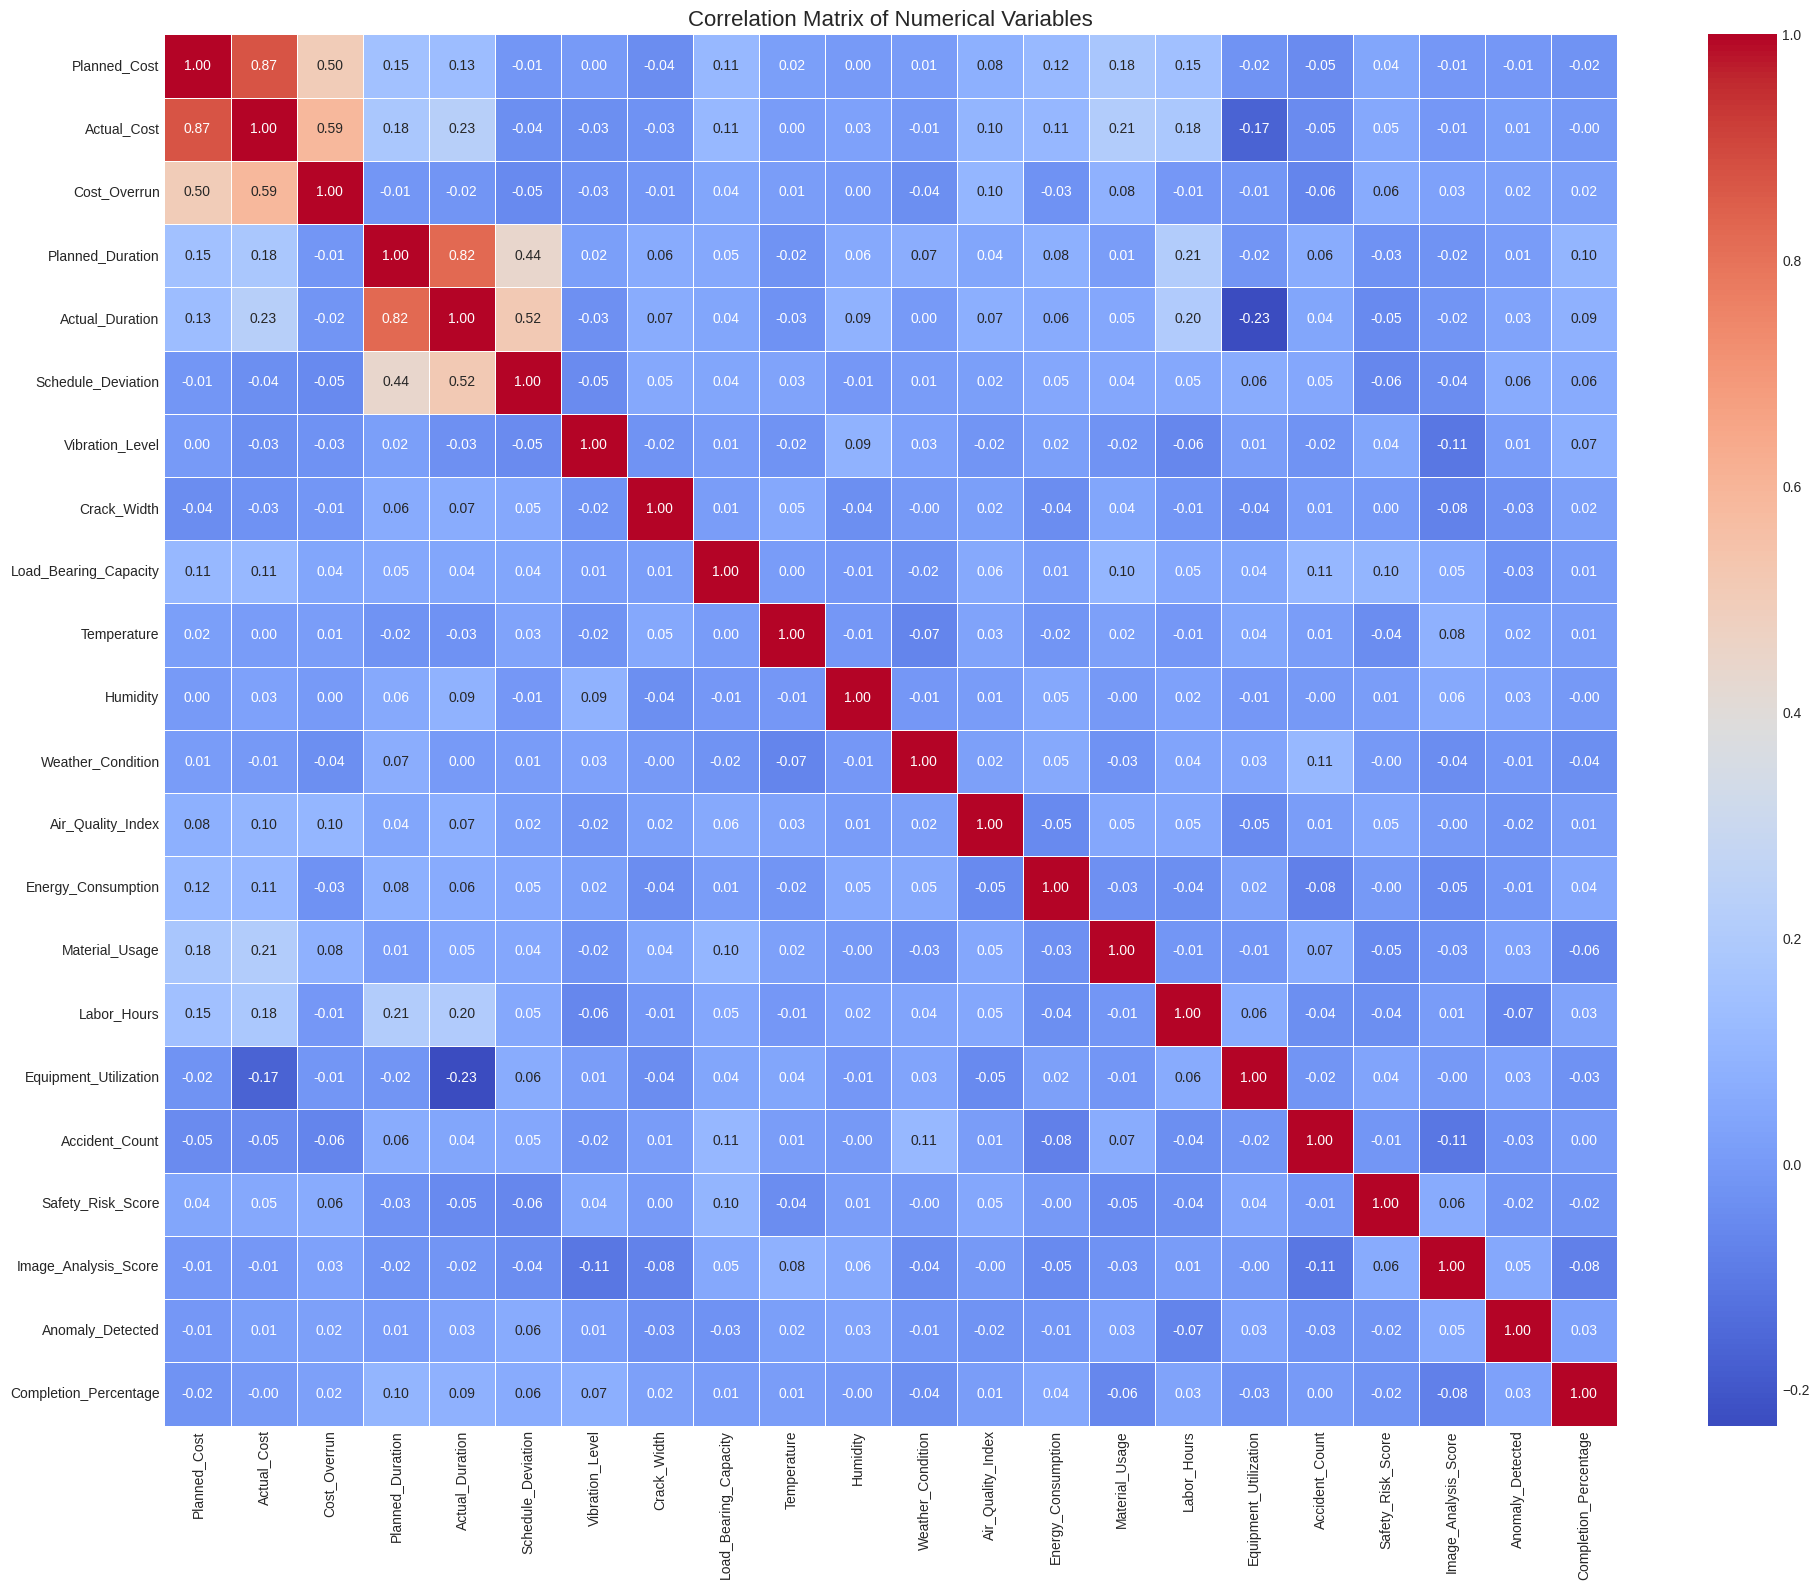

In [ ]:
# 5. STEP 5: CORRELATION ANALYSIS
# ===============================
# Upload the dataset without outliers
uploaded = files.upload()
file_name = next(iter(uploaded))  # Get the name of the uploaded file
df = pd.read_excel(file_name)  # Load the uploaded Excel file

# Select only numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Create correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Save correlation matrix to CSV
correlation_matrix_path = "correlation_matrix.csv"
correlation_matrix.to_csv(correlation_matrix_path)
files.download(correlation_matrix_path)

# Create a heatmap visualization of the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_heatmap.png", dpi=300, bbox_inches='tight')  # Save heatmap
files.download("correlation_matrix_heatmap.png")  # Download the heatmap

print("Correlation matrix created and saved as CSV and heatmap visualization.")

# Generate a markdown summary of key correlations
correlation_summary = """# Correlation Analysis

## Correlation Matrix
The correlation matrix shows the Pearson correlation coefficients between all numerical variables in the dataset.

## Key Correlations

### Strong Positive Correlations (> 0.1)
"""

# Find strong positive correlations
strong_positive = []
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        if correlation_matrix.iloc[i, j] > 0.1:
            strong_positive.append((numerical_cols[i], numerical_cols[j], correlation_matrix.iloc[i, j]))

for var1, var2, corr in sorted(strong_positive, key=lambda x: x[2], reverse=True):
    correlation_summary += f"- {var1} and {var2}: {corr:.1f}\n"

correlation_summary += "\n### Strong Negative Correlations (< -0.1)\n"

# Find strong negative correlations
strong_negative = []
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        if correlation_matrix.iloc[i, j] < -0.1:
            strong_negative.append((numerical_cols[i], numerical_cols[j], correlation_matrix.iloc[i, j]))

for var1, var2, corr in sorted(strong_negative, key=lambda x: x[2]):
    correlation_summary += f"- {var1} and {var2}: {corr:.1f}\n"

# Optionally print or save the correlation summary
print(correlation_summary)

Saving data_no_outliers.xlsx to data_no_outliers (2).xlsx
Loaded file: data_no_outliers (2).xlsx
Categorical columns for embedding: ['Project_Type', 'Location', 'Weather_Condition']
Loading sentence transformer model...

Generating embeddings for column: Project_Type
  Unique values: ['Tunnel', 'Building', 'Dam', 'Road', 'Bridge']
  Generated embeddings shape: (5, 384)

Generating embeddings for column: Location
  Unique values: ['Houston', 'Seattle', 'New York', 'Chicago', 'Los Angeles']
  Generated embeddings shape: (5, 384)

Generating embeddings for column: Weather_Condition
  Unique values: [4, 2, 1, 3, 5]
  Generated embeddings shape: (5, 384)

Columns after adding embeddings: ['Project_ID', 'Start_Date', 'End_Date', 'Planned_Cost', 'Actual_Cost', 'Cost_Overrun', 'Planned_Duration', 'Actual_Duration', 'Schedule_Deviation', 'Vibration_Level', 'Crack_Width', 'Load_Bearing_Capacity', 'Temperature', 'Humidity', 'Air_Quality_Index', 'Energy_Consumption', 'Material_Usage', 'Labor_Hours

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


First 5 rows of the dataset with embeddings:
| Project_ID   | Start_Date          | End_Date            |   Planned_Cost |   Actual_Cost |   Cost_Overrun |   Planned_Duration |   Actual_Duration |   Schedule_Deviation |   Vibration_Level |   Weather_Condition_Emb_374 |   Weather_Condition_Emb_375 |   Weather_Condition_Emb_376 |   Weather_Condition_Emb_377 |   Weather_Condition_Emb_378 |   Weather_Condition_Emb_379 |   Weather_Condition_Emb_380 |   Weather_Condition_Emb_381 |   Weather_Condition_Emb_382 |   Weather_Condition_Emb_383 |
|:-------------|:--------------------|:--------------------|---------------:|--------------:|---------------:|-------------------:|------------------:|---------------------:|------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-------------------------

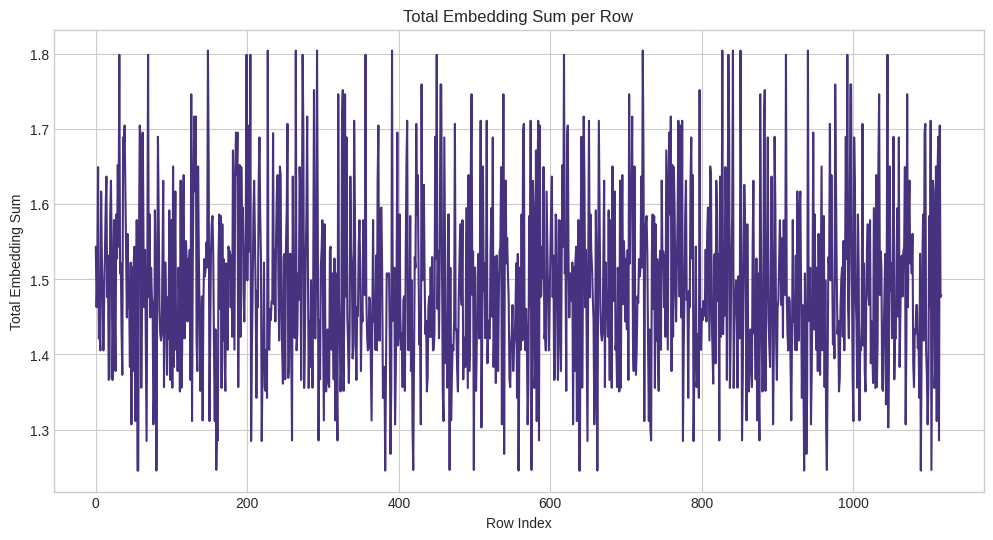

In [ ]:
# 1. Upload file
uploaded = files.upload()
file_path = next(iter(uploaded))
print(f"Loaded file: {file_path}")

# 2. Load the dataset (auto-detect file type)
if file_path.lower().endswith('.csv'):
    df = pd.read_csv(file_path)
elif file_path.lower().endswith(('.xls', '.xlsx')):
    df = pd.read_excel(file_path)
else:
    raise ValueError("Unsupported file type. Please upload a CSV or Excel file.")

# 3. Define categorical columns for embedding
categorical_cols_for_embedding = [col for col in ['Project_Type', 'Location', 'Weather_Condition'] if col in df.columns]
print("Categorical columns for embedding:", categorical_cols_for_embedding)

# 4. Load sentence transformer model
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

df_with_embeddings = df.copy()

# 5. Generate embeddings for each categorical column
for col in categorical_cols_for_embedding:
    print(f"\nGenerating embeddings for column: {col}")
    unique_values = df[col].unique().tolist()
    print(f"  Unique values: {unique_values}")

    # Convert all unique values to strings for embedding
    embeddings = model.encode([str(val) for val in unique_values])
    print(f"  Generated embeddings shape: {embeddings.shape}")

    # Create a mapping from unique value to its embedding
    embedding_map = {value: emb for value, emb in zip(unique_values, embeddings)}

    # Create new columns for the embeddings in the main dataframe
    embedding_dim = embeddings.shape[1]
    embedding_cols = [f'{col}_Emb_{i}' for i in range(embedding_dim)]

    # Initialize new columns with NaNs or zeros
    for new_col in embedding_cols:
        df_with_embeddings[new_col] = np.nan
        df_with_embeddings[new_col] = df_with_embeddings[new_col].astype(float)

    # Map embeddings to the dataframe rows
    temp_embeddings = df_with_embeddings[col].apply(lambda x: embedding_map[x])
    embedding_array = np.stack(temp_embeddings.values)
    df_embeddings_temp = pd.DataFrame(embedding_array, index=df_with_embeddings.index, columns=embedding_cols)
    df_with_embeddings.update(df_embeddings_temp)

# 6. Drop the original categorical columns that were embedded
df_with_embeddings = df_with_embeddings.drop(columns=categorical_cols_for_embedding)

print("\nColumns after adding embeddings:", df_with_embeddings.columns.tolist())

# 7. Save the data with embeddings
output_file_path = "data_with_embeddings.csv"
df_with_embeddings.to_csv(output_file_path, index=False)
print(f"\nData with embeddings saved to {output_file_path}")

# 8. Download the file to the user's computer
files.download(output_file_path)

# 9. Display first 5 rows of the data with embeddings
print("\nFirst 5 rows of the dataset with embeddings:")
display_cols = df_with_embeddings.columns[:10].tolist() + df_with_embeddings.columns[-10:].tolist()
print(df_with_embeddings[display_cols].head().to_markdown(index=False))

# 10. Plot the total (sum) of all embedding columns for each row
embedding_columns = [col for col in df_with_embeddings.columns if '_Emb_' in col]
df_with_embeddings['Total_Embedding_Sum'] = df_with_embeddings[embedding_columns].sum(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(df_with_embeddings['Total_Embedding_Sum'])
plt.title('Total Embedding Sum per Row')
plt.xlabel('Row Index')
plt.ylabel('Total Embedding Sum')
plt.grid(True)
plt.show()

In [ ]:
# =========================
# STEP 1: Upload the Excel File
# =========================
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your Excel file

# =========================
# STEP 2: Read the Excel File
# =========================
import pandas as pd

filename = next(iter(uploaded))
df = pd.read_excel(filename)
df.head()

# =========================
# # STEP 3: Prepare Features and Target (Use All Parameters, Handle Dates)
# =========================

exclude_cols = [
    'Project_ID',      # Identifier, not a feature
    'Actual_Cost'      # Target variable
]

# Identify categorical columns (object or string types)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Identify datetime columns
datetime_cols = df.select_dtypes(include=['datetime', 'datetime64[ns]']).columns.tolist()

# Option 1: Convert dates to numeric features (example: project duration)
if 'Start_Date' in df.columns and 'End_Date' in df.columns:
    df['Project_Duration_Days'] = (pd.to_datetime(df['End_Date']) - pd.to_datetime(df['Start_Date'])).dt.days

# Drop original datetime columns
df = df.drop(columns=datetime_cols)

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Prepare features (X) and target (y)
feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]
X = df_encoded[feature_cols]
y = df['Actual_Cost']

# =========================
# STEP 4: Split Data into Train and Test Sets
# =========================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# STEP 5: Normalize Features
# =========================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =========================
# STEP 6: Build and Train the ANN Model for Regression
# =========================
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, input_shape=(X_train.shape[1],)),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Saving data_with_embeddings.xlsx to data_with_embeddings (22).xlsx
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2980745958129664.0000 - mae: 45932712.0000 - val_loss: 3599094010347520.0000 - val_mae: 50294556.0000
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3087995854913536.0000 - mae: 46337676.0000 - val_loss: 3324033567293440.0000 - val_mae: 47544484.0000
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2449550040104960.0000 - mae: 40499972.0000 - val_loss: 1734702796898304.0000 - val_mae: 30746598.0000
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1130912938983424.0000 - mae: 25642784.0000 - val_loss: 1130800867180544.0000 - val_mae: 25875344.0000
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 916280135647232.0000 - mae: 24003510.0000 - val_loss: 1053750093414400.0000 - val_mae: 25090340.0000
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 827143189692416.0000 - mae: 22993498.0000 - val_loss: 1017387356782592

In [ ]:
                                                                            # =============================================================================
                                                                                                        #  Machine Learning
                                                                            # =============================================================================

# =========================
# STEP 1: Upload the Excel File
# =========================
# This step is specific to Google Colab.
# When running in a local environment, replace with standard file reading.
try:
    from google.colab import files
    uploaded = files.upload()  # This will prompt you to upload your Excel file
    filename = next(iter(uploaded))
    print(f"File '{filename}' uploaded successfully.")
except ImportError:
    print("google.colab.files not found. Assuming running in a local environment.")
    # In a local environment, you would specify the file path directly
    # filename = 'your_excel_file.xlsx' # <-- Specify your file path here
    # Ensure you have a file named 'your_excel_file.xlsx' in the same directory
    # or provide the full path.
    print("Please adjust STEP 1 to load your file from a local path.")
    filename = input("Enter the path to your Excel file: ") # Example for local

# =========================
# STEP 2: Read the Excel File and Import Libraries
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


try:
    df = pd.read_excel(filename)
    print(f"\nSuccessfully read '{filename}'.")
    print("\nFirst 5 rows of the dataframe:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
except FileNotFoundError:
    print(f"Error: File '{filename}' not found.")
    # Exit or handle the error appropriately if the file isn't loaded/found
    exit()
except Exception as e:
    print(f"Error reading Excel file: {e}")
    exit()


# =========================
# # STEP 3: Prepare Features and Target (Handle Dates, Categoricals, Transform)
# =========================

exclude_cols = [
    'Project_ID',      # Identifier, not a feature
    'Actual_Cost'      # Target variable
]

# Identify categorical columns (object or string types)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
print(f"\nIdentified categorical columns: {categorical_cols}")


# Identify datetime columns
datetime_cols = df.select_dtypes(include=['datetime', 'datetime64[ns]']).columns.tolist()
print(f"Identified datetime columns: {datetime_cols}")

# Option 1: Convert dates to numeric features (example: project duration)
# Ensure Start_Date and End_Date exist and are not in exclude_cols before calculating duration
date_duration_cols_present = all(col in df.columns and col not in exclude_cols for col in ['Start_Date', 'End_Date'])
if date_duration_cols_present:
     try:
        # Ensure columns are datetime objects before calculating difference
        # Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
        df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce')
        df['End_Date'] = pd.to_datetime(df['End_Date'], errors='coerce')
        # Calculate duration, resulting NaT or NaN values will propagate
        df['Project_Duration_Days'] = (df['End_Date'] - df['Start_Date']).dt.days
        print("\nAdded 'Project_Duration_Days' feature.")
        # Handle potential NaNs created by coercion
        df['Project_Duration_Days'].fillna(df['Project_Duration_Days'].median(), inplace=True) # Example: fill NaNs with median
        print("Filled NaN values in 'Project_Duration_Days' with the median.")

     except Exception as e:
        print(f"Could not calculate Project_Duration_Days. Error: {e}")
else:
    missing_cols = [col for col in ['Start_Date', 'End_Date'] if col not in df.columns or col in exclude_cols]
    if missing_cols:
        print(f"\nCould not calculate Project_Duration_Days. Missing or excluded columns: {missing_cols}")


# Drop original datetime columns if they were identified
if datetime_cols:
    df = df.drop(columns=datetime_cols)
    print(f"Dropped original datetime columns: {datetime_cols}")


# One-hot encode categorical columns
if categorical_cols:
    # Handle potential NaNs in categorical columns before encoding
    for col in categorical_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna('Missing') # Example: fill NaNs with a 'Missing' category
            print(f"Filled NaN values in categorical column '{col}' with 'Missing'.")

    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"\nApplied one-hot encoding to columns: {categorical_cols}")
    print(f"Shape after encoding: {df_encoded.shape}")
else:
    df_encoded = df.copy()
    print("\nNo categorical columns to encode (excluding excluded columns).")


# Prepare features (X) and target (y)
# Ensure 'Actual_Cost' is in df before preparing y
X = None
y = None
y_transformed = None
X_scaled = None

if 'Actual_Cost' in df.columns:
    y = df['Actual_Cost']
    # Ensure feature_cols exist in df_encoded and are not in exclude_cols
    feature_cols = [col for col in df_encoded.columns if col not in exclude_cols and col in df_encoded.columns]
    X = df_encoded[feature_cols]
    print(f"\nPrepared features (X) with shape: {X.shape}")
    print(f"Prepared target (y) with shape: {y.shape}")

    # =========================
    # Added: Log Transform the Target Variable
    # =========================
    # Apply log transformation to 'Actual_Cost' (adding 1 to handle zeros)
    try:
        y_transformed = np.log1p(y)
        print("Applied log1p transformation to the target variable (Actual_Cost).")
    except Exception as e:
        print(f"Could not apply log transformation to target. Error: {e}")
        y_transformed = None # Set to None if transformation fails

    # =========================
    # Added: Feature Standardization
    # =========================
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print("Applied feature standardization.")
        print(f"Shape after standardization: {X_scaled.shape}")
    except Exception as e:
        print(f"Could not apply feature standardization. Error: {e}")
        X_scaled = None # Set to None if standardization fails

else:
    print("\n'Actual_Cost' column not found in the dataframe. Cannot prepare target variable.")


# =========================
# STEP 4: Split Data into Train and Test Sets
# =========================
# Use the transformed target and scaled features for the split
X_train, X_test, y_train_transformed, y_test_transformed = None, None, None, None
y_test_original = None # To store original y_test for evaluation

if X_scaled is not None and y_transformed is not None:
    X_train, X_test, y_train_transformed, y_test_transformed = train_test_split(
        X_scaled, y_transformed, test_size=0.2, random_state=42
    )
    print(f"\nData split into training and testing sets (test_size=0.2) using transformed data:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train_transformed shape: {y_train_transformed.shape}")
    print(f"y_test_transformed shape: {y_test_transformed.shape}")

    # Re-split the original data *before* transformation to get original y_test for evaluation purposes
    if 'Actual_Cost' in df.columns:
         X_original = df_encoded[feature_cols] # Features before scaling
         y_original = df['Actual_Cost'] # Original target
         # Perform a split just to get the original y_test for the same indices as X_test
         # Use the same random_state to ensure the split is identical
         _, _, _, y_test_original = train_test_split(
            X_original, y_original, test_size=0.2, random_state=42
         )
         print("Retrieved original y_test for evaluation.")
    else:
         print("Could not retrieve original y_test for evaluation.")

else:
    print("\nSkipping data split as features or target could not be prepared or transformed.")


# =========================
# Added: Save Processed Data to CSV for Google Colab
# =========================
if X_train is not None and X_test is not None and y_train_transformed is not None and y_test_transformed is not None and y_test_original is not None:
    try:
        # Convert NumPy arrays to DataFrames/Series for saving with headers
        # X_train and X_test are NumPy arrays from StandardScaler, convert to DataFrame
        # Use original column names if available, otherwise default naming
        if X is not None and feature_cols is not None: # Check if original X and feature_cols were successfully created
            X_train_df = pd.DataFrame(X_train, columns=feature_cols)
            X_test_df = pd.DataFrame(X_test, columns=feature_cols)
        else: # Fallback if original column names aren't easily accessible after scaling
             X_train_df = pd.DataFrame(X_train)
             X_test_df = pd.DataFrame(X_test)
             print("Warning: Original column names not available after scaling. Saving X_train and X_test without original headers.")


        y_train_transformed_series = pd.Series(y_train_transformed)
        y_test_transformed_series = pd.Series(y_test_transformed)
        # y_test_original is already a Pandas Series

        # Save to CSV files
        X_train_df.to_csv('X_train.csv', index=False)
        X_test_df.to_csv('X_test.csv', index=False)
        y_train_transformed_series.to_csv('y_train_transformed.csv', index=False, header=['Actual_Cost_transformed']) # Add header for clarity
        y_test_transformed_series.to_csv('y_test_transformed.csv', index=False, header=['Actual_Cost_transformed'])
        y_test_original.to_csv('y_test_original.csv', index=False, header=['Actual_Cost_original']) # Add header

        print("\nSaved processed data to CSV files:")
        print("- X_train.csv")
        print("- X_test.csv")
        print("- y_train_transformed.csv")
        print("- y_test_transformed.csv")
        print("- y_test_original.csv")

        print("\nYou can now download these files and upload them to Google Colab.")

    except Exception as e:
        print(f"\nError saving data to CSV: {e}")

# Helper function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE).
    Handles cases where y_true is zero by excluding those points.
    """
    # Convert to numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Filter out points where y_true is zero to avoid division by zero
    non_zero_indices = y_true != 0
    if non_zero_indices.sum() == 0:
        print("Warning: All actual values are zero, MAPE cannot be calculated.")
        return np.nan # Return NaN if all true values are zero

    y_true_filtered = y_true[non_zero_indices]
    y_pred_filtered = y_pred[non_zero_indices]

    # Calculate absolute percentage error
    ape = np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered) * 100

    # Return the mean APE
    return np.mean(ape)


# Initialize dictionaries to store results
results = {}
predictions = {}
y_test_for_eval = y_test_original if y_test_original is not None else None

Saving data_with_embeddings.xlsx to data_with_embeddings (23).xlsx
File 'data_with_embeddings (23).xlsx' uploaded successfully.

Successfully read 'data_with_embeddings (23).xlsx'.

First 5 rows of the dataframe:
  Start_Date   End_Date  Planned_Cost   Actual_Cost  Cost_Overrun  \
0 2020-01-01 2021-09-26    12260784.0  1.689327e+07  2.793720e+06   
1 2020-01-03 2021-12-05    23299783.0  3.245837e+07 -1.607656e+06   
2 2020-01-04 2022-04-12    24499306.0  3.715338e+07  4.970354e+06   
3 2020-01-06 2020-09-18    16711072.0  3.174928e+07  6.978281e+06   
4 2020-01-08 2021-09-19    42776934.0  6.021785e+07  1.625532e+07   

   Planned_Duration  Actual_Duration  Schedule_Deviation  Vibration_Level  \
0             699.0       850.984231          114.914852         1.534172   
1             899.0      1695.934895          182.777915         0.951146   
2             809.0      1308.192026          165.565655         0.870396   
3             255.0       400.203978          124.859150        

<ipython-input-8-55d5e479e712>:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Project_Duration_Days'].fillna(df['Project_Duration_Days'].median(), inplace=True) # Example: fill NaNs with median



Saved processed data to CSV files:
- X_train.csv
- X_test.csv
- y_train_transformed.csv
- y_test_transformed.csv
- y_test_original.csv

You can now download these files and upload them to Google Colab.


In [ ]:
                                                                                    # =========================
                                                                                        #Random Forest Model
                                                                                    # =========================
print("\n====== Training Random Forest Model ======")

# Check if data is available for training
if X_train is not None and y_train_transformed is not None and X_test is not None and y_test_for_eval is not None:
    try:
        # Initialize the Random Forest Regressor
        # Using default n_estimators=100 and random_state=42 as in your snippet
        model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

        # Train the model on transformed and scaled data
        model_rf.fit(X_train, y_train_transformed)
        print("Random Forest model trained successfully on transformed data.")

        # Make predictions on the scaled test data
        y_pred_transformed = model_rf.predict(X_test)

        # Inverse transform the predictions to the original scale
        y_pred_original_scale = np.expm1(y_pred_transformed) # Use expm1 to invert log1p

        # Evaluate the model using original scale predictions and original y_test
        print("\nEvaluating Random Forest model on original scale...")
        rmse_rf = np.sqrt(mean_squared_error(y_test_for_eval, y_pred_original_scale))
        mae_rf = mean_absolute_error(y_test_for_eval, y_pred_original_scale)
        r2_rf = r2_score(y_test_for_eval, y_pred_original_scale)
        mape_rf = calculate_mape(y_test_for_eval, y_pred_original_scale)

        # Store results
        results['Random Forest'] = {
            'RMSE': rmse_rf,
            'MAE': mae_rf,
            'R-squared': r2_rf,
            'MAPE': mape_rf
        }
        # Store predictions (on original scale)
        predictions['Random Forest'] = y_pred_original_scale

        # Print evaluation metrics
        print(f"Random Forest Model Evaluation (on original scale):")
        print(f"  RMSE: {results['Random Forest']['RMSE']:.2f}")
        print(f"  MAE: {results['Random Forest']['MAE']:.2f}")
        print(f"  R-squared: {results['Random Forest']['R-squared']:.2f}")
        print(f"  MAPE: {results['Random Forest']['MAPE']:.2f}%" if not np.isnan(results['Random Forest']['MAPE']) else "  MAPE: N/A")

    except Exception as e:
        print(f"\nError during Random Forest model training or evaluation: {e}")
else:
    print("\nSkipping Random Forest model training and evaluation due to missing data.")


====== Training Random Forest Model ======
Random Forest model trained successfully on transformed data.

Evaluating Random Forest model on original scale...
Random Forest Model Evaluation (on original scale):
  RMSE: 7813253.95
  MAE: 5072950.34
  R-squared: 0.93
  MAPE: 12.56%



K-Fold Cross-Validation (k=5) MAE scores:
Fold 1: 5061676.6144
Fold 2: 6114232.3634
Fold 3: 5744754.7909
Fold 4: 5737881.8822
Fold 5: 6261470.5231

Average MAE across folds: 5784003.2348
Standard deviation of MAE across folds: 415319.0713


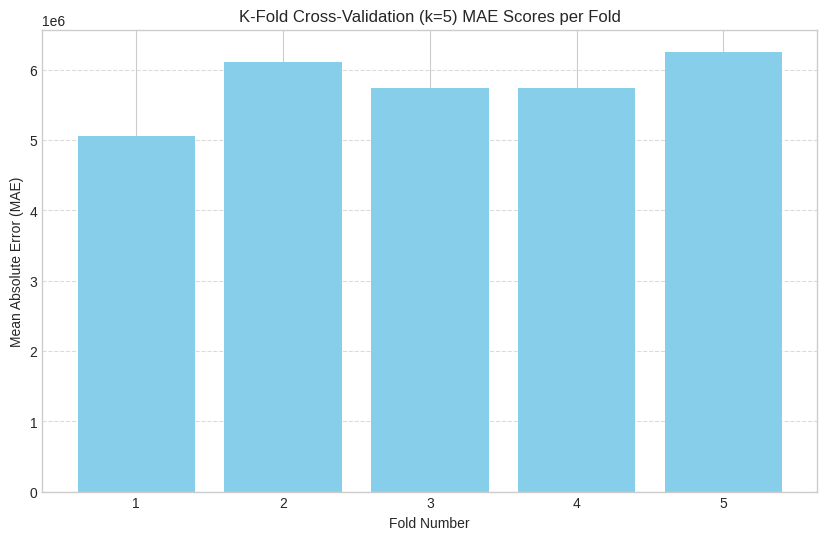


Average MAE across folds: 5784003.2348
Standard deviation of MAE across folds: 415319.0713
Test MAE: 5025618.0721
OOB score not available. Ensure oob_score=True was set during model initialization.


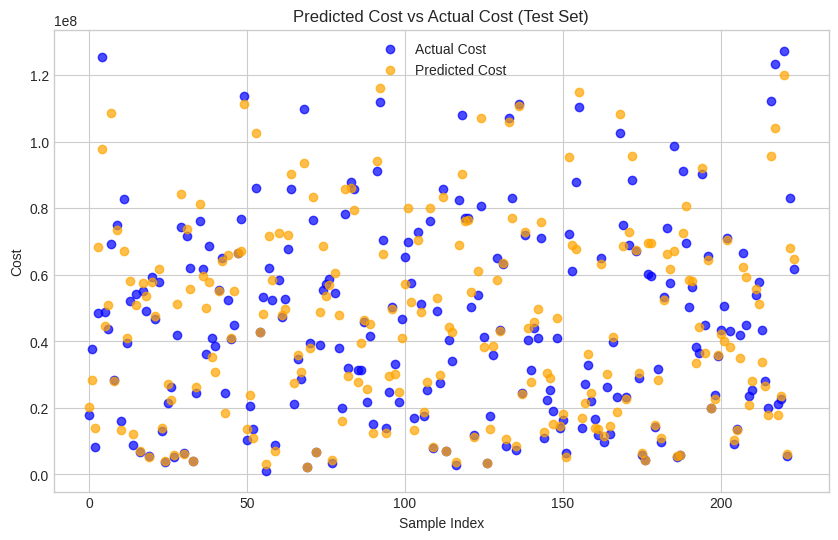

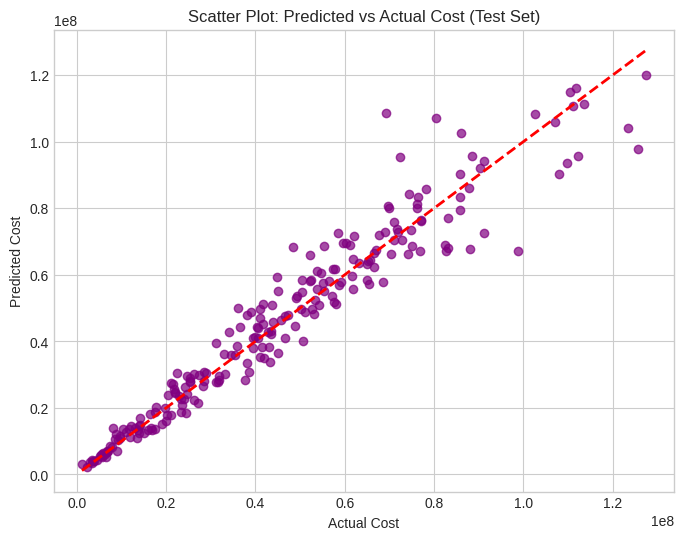

In [ ]:
                                                                                 # =========================
                                                                              # Random Forest Model Evaluation
                                                                                 # =========================
# =========================
# STEP 9: K-Fold Cross-Validation
# =========================
from sklearn.model_selection import KFold, cross_val_score

# Define the number of folds
k = 5 # You can change this value, commonly 5 or 10

# Initialize K-Fold cross-validator
# shuffle=True and random_state are important for randomness
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
# We use the 'neg_mean_absolute_error' scoring because cross_val_score
# calculates scores for maximization (higher is better).
# MAE is a minimization metric (lower is better), so we use the negative.
# The 'model' variable is assumed to be your trained RandomForestRegressor
# from STEP 5, using the full dataset (X, y).
# Note: For cross-validation, it's standard to use the model instance trained
# on the *full* dataset (or often, a fresh instance), not the one trained
# specifically on X_train from the single train/test split.
# However, since your RandomForestRegressor model instance 'model' is already defined
# and fitted (presumably on X_train, y_train based on your previous steps),
# we'll use that instance for cross-validation on the full X and y.
# A more rigorous approach might re-initialize the model here.

cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1) # Use n_jobs=-1 for parallel processing

# Convert negative scores to positive MAE
mae_scores = -cv_scores

print(f"\nK-Fold Cross-Validation (k={k}) MAE scores:")
for fold, score in enumerate(mae_scores):
    print(f"Fold {fold+1}: {score:.4f}")

print(f"\nAverage MAE across folds: {mae_scores.mean():.4f}")
print(f"Standard deviation of MAE across folds: {mae_scores.std():.4f}")



import matplotlib.pyplot as plt # Ensure matplotlib is imported
import numpy as np # Ensure numpy is imported

# Assuming mae_scores list/array is available from the previous step

plt.figure(figsize=(10, 6))
folds = range(1, k + 1) # Create labels for each fold (1 to k)

plt.bar(folds, mae_scores, color='skyblue')
plt.xlabel('Fold Number')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'K-Fold Cross-Validation (k={k}) MAE Scores per Fold')
plt.xticks(folds) # Ensure x-axis ticks correspond to fold numbers
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for readability
plt.show()

print(f"\nAverage MAE across folds: {mae_scores.mean():.4f}")
print(f"Standard deviation of MAE across folds: {mae_scores.std():.4f}")
# =========================
# STEP 10: Evaluate the Model on the Test Set (Regression)
# =========================

# Predict actual costs for the test set
y_pred = model.predict(X_test).flatten() # Use flatten() if predict returns a 2D array

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")

# Print Out-of-Bag (OOB) Score
# The OOB score is automatically calculated if oob_score=True is set
if hasattr(model, 'oob_score_') and model.oob_score_ is not None:
    print(f"Out-of-Bag (OOB) Score: {model.oob_score_:.4f}")
else:
    print("OOB score not available. Ensure oob_score=True was set during model initialization.")

# =========================
# STEP 11: Plot Predicted Cost and Actual Cost with Different Colors
# =========================

plt.figure(figsize=(10, 6))
indices = np.arange(len(y_test))

plt.scatter(indices, y_test, color='blue', label='Actual Cost', alpha=0.7)
plt.scatter(indices, y_pred, color='orange', label='Predicted Cost', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Cost')
plt.title('Predicted Cost vs Actual Cost (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# =========================
# STEP 12: Scatter Plot of Predictions (Predicted Cost vs Actual Cost)
# =========================
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
# Add a line representing perfect predictions (where predicted equals actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Scatter Plot: Predicted vs Actual Cost (Test Set)')
plt.grid(True)
plt.show()


In [ ]:
                                                                                 # =========================
                                                                                      # XGBoost Model
                                                                                 # =========================
# =========================
# STEP 6: Build and Train the XGBoost Model for Regression
# =========================
print("\n====== Training XGBoost Model ======")

# Check if data is available for training
if X_train is not None and y_train_transformed is not None and X_test is not None and y_test_for_eval is not None:
    try:
        # Initialize the XGBoost Regressor
        # Using objective 'reg:squarederror' suitable for regression on transformed data
        model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                     n_estimators=100,
                                     learning_rate=0.1,
                                     random_state=42)

        # Train the model on transformed and scaled data
        model_xgb.fit(X_train, y_train_transformed)
        print("XGBoost model trained successfully on transformed data.")

        # Make predictions on the scaled test data
        y_pred_transformed_xgb = model_xgb.predict(X_test)

        # Inverse transform the predictions to the original scale
        y_pred_original_scale_xgb = np.expm1(y_pred_transformed_xgb) # Use expm1 to invert log1p

        # Evaluate the model using original scale predictions and original y_test
        print("\nEvaluating XGBoost model on original scale...")
        rmse_xgb = np.sqrt(mean_squared_error(y_test_for_eval, y_pred_original_scale_xgb))
        mae_xgb = mean_absolute_error(y_test_for_eval, y_pred_original_scale_xgb)
        r2_xgb = r2_score(y_test_for_eval, y_pred_original_scale_xgb)
        mape_xgb = calculate_mape(y_test_for_eval, y_pred_original_scale_xgb)

        # Store results
        results['XGBoost'] = {
            'RMSE': rmse_xgb,
            'MAE': mae_xgb,
            'R-squared': r2_xgb,
            'MAPE': mape_xgb
        }
        # Store predictions (on original scale)
        predictions['XGBoost'] = y_pred_original_scale_xgb

        # Print evaluation metrics
        print(f"XGBoost Model Evaluation (on original scale):")
        print(f"  RMSE: {results['XGBoost']['RMSE']:.2f}")
        print(f"  MAE: {results['XGBoost']['MAE']:.2f}")
        print(f"  R-squared: {results['XGBoost']['R-squared']:.2f}")
        print(f"  MAPE: {results['XGBoost']['MAPE']:.2f}%" if not np.isnan(results['XGBoost']['MAPE']) else "  MAPE: N/A")

    except Exception as e:
        print(f"\nError during XGBoost model training or evaluation: {e}")
else:
    print("\nSkipping XGBoost model training and evaluation due to missing data.")


====== Training XGBoost Model ======
XGBoost model trained successfully on transformed data.

Evaluating XGBoost model on original scale...
XGBoost Model Evaluation (on original scale):
  RMSE: 8027112.82
  MAE: 5096150.61
  R-squared: 0.92
  MAPE: 12.47%



====== Evaluating and Plotting XGBoost Results ======
Test MAE (XGBoost, original scale): 5096150.6108


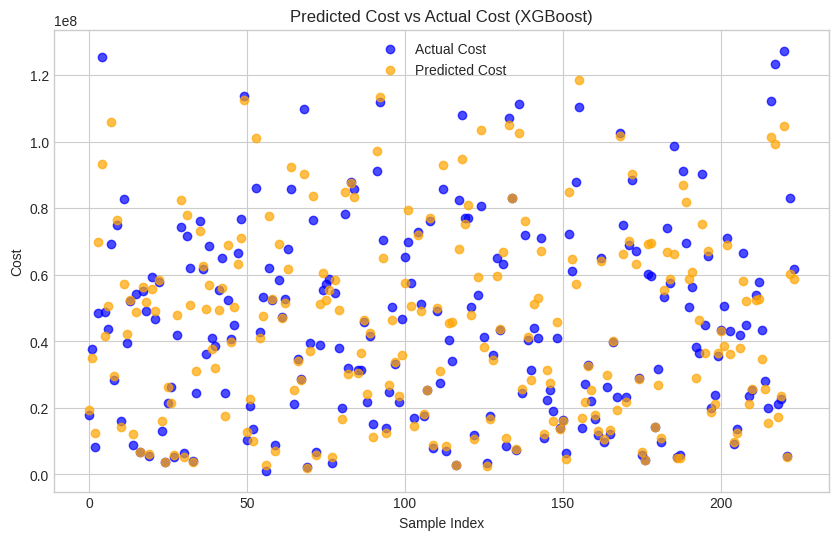

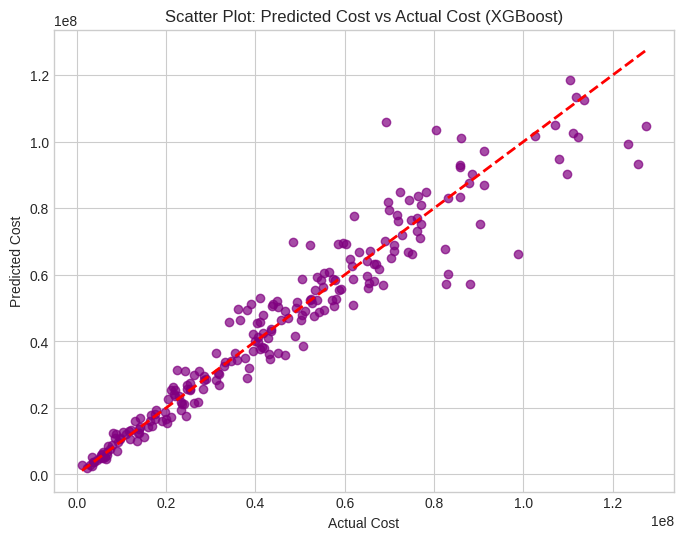


Generating Learning Curve for XGBoost...


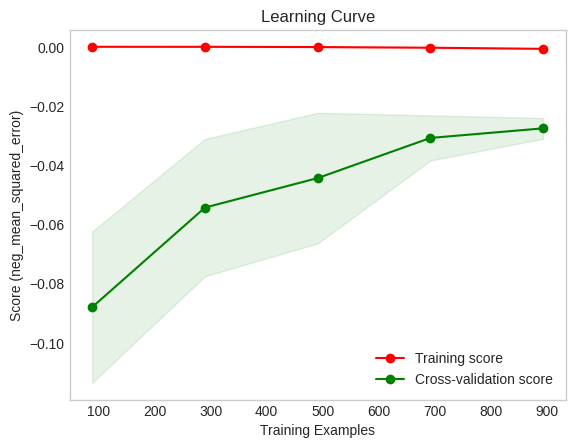

In [ ]:
                                                                                 # =========================
                                                                                  # XGBoost Model Evaluation
                                                                                 # =========================
print("\n====== Evaluating and Plotting XGBoost Results ======")

# Check if necessary data and predictions are available
if y_test_for_eval is not None and 'XGBoost' in predictions:
    try:
        y_test_eval = y_test_for_eval
        y_pred_eval = predictions['XGBoost'] # Use predictions from XGBoost model

        # Ensure y_test_eval and y_pred_eval are numpy arrays for consistent operations
        y_test_eval = np.array(y_test_eval)
        y_pred_eval = np.array(y_pred_eval)

        # =========================
        # Evaluate the Model on the Test Set (Regression)
        # =========================

        # Calculate Mean Absolute Error (MAE) using original scale values
        mae = mean_absolute_error(y_test_eval, y_pred_eval)
        print(f"Test MAE (XGBoost, original scale): {mae:.4f}")

        # =========================
        # Plot Predicted Cost and Actual Cost with Different Colors
        # =========================
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        indices = np.arange(len(y_test_eval))

        plt.scatter(indices, y_test_eval, color='blue', label='Actual Cost', alpha=0.7)
        plt.scatter(indices, y_pred_eval, color='orange', label='Predicted Cost', alpha=0.7)
        plt.xlabel('Sample Index')
        plt.ylabel('Cost')
        plt.title('Predicted Cost vs Actual Cost (XGBoost)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # =========================
        # Scatter Plot of Predictions (Predicted Cost vs Actual Cost)
        # =========================
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_eval, y_pred_eval, alpha=0.7, color='purple')
        # Adding a line representing perfect predictions
        # Use min/max from both actual and predicted for the perfect line range
        min_val = min(y_test_eval.min(), y_pred_eval.min())
        max_val = max(y_test_eval.max(), y_pred_eval.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        plt.xlabel('Actual Cost')
        plt.ylabel('Predicted Cost')
        plt.title('Scatter Plot: Predicted Cost vs Actual Cost (XGBoost)')
        plt.grid(True)
        plt.show()

        # =========================
        # Plot Learning Curve
        # =========================

        # Define the learning curve plotting function
        def plot_learning_curve(estimator, X, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
            """
            Generate a simple plot of the test and training learning curve.

            Parameters
            ----------
            estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

            X : array-like, shape (n_samples, n_features)
                Training vector, where n_samples is the number of samples and
                n_features is the number of features.

            y : array-like, shape (n_samples) or (n_samples, n_features), optional
                Target relative to X for classification or regression;
                None for unsupervised learning.

            scoring : string, callable or None, default=None
                A string (see model evaluation documentation) or
                a scorer callable object / function with signature
                ``scorer(estimator, X, y)``. By default, ``scoring=None``, which
                forces the estimator to be used.

            cv : int, cross-validation generator or an iterable, default=5
                Determines the cross-validation splitting strategy.
                Possible inputs for cv are:
                  - None, to use the default 5-fold cross-validation,
                  - integer, to specify the number of folds.

            n_jobs : int, default=None
                Number of jobs to run in parallel (for cross-validation).
                ``-1`` means using all processors.

            train_sizes : array-like, shape (n_ticks,), dtype non-float, default=
                np.linspace(0.1, 1.0, 5)
                Relative or absolute numbers of training examples that will be used to
                generate the learning curve. If the dtype is float, it is interpreted as a
                fraction of the maximum number of training examples (rounded down).
                If the dtype is int, it is interpreted as the absolute number of training
                examples.
            """
            plt.figure()
            plt.title("Learning Curve")
            plt.xlabel("Training Examples")
            plt.ylabel(f"Score ({scoring})")

            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")

            plt.legend(loc="best")
            plt.show()


        # Check if data and model are available for learning curve
        if X_scaled is not None and y_transformed is not None and 'model_xgb' in locals():
             print("\nGenerating Learning Curve for XGBoost...")
             # Call the function to plot the learning curve
             # Use the scaled features (X_scaled) and transformed target (y_transformed)
             # Use the trained XGBoost model instance (model_xgb)
             plot_learning_curve(model_xgb, X_scaled, y_transformed, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
        else:
             print("\nSkipping Learning Curve plot due to missing data or model.")


    except Exception as e:
        print(f"\nError during evaluation or plotting: {e}")
else:
    print("\nSkipping evaluation and plotting due to missing data or predictions.")


====== Training Stacked Model ======

Training the stacked model on transformed target variable...
Stacked model training complete.

Predictions made on the test set (in log-transformed scale).
Inverse transformed predictions back to original scale.

Evaluating Stacked model on original scale...

Stacked Model Evaluation (on original scale):
  RMSE: 7807016.36
  MAE: 4989385.08
  R-squared: 0.93
  MAPE: 12.23%

Generating visualization (on original scale)...



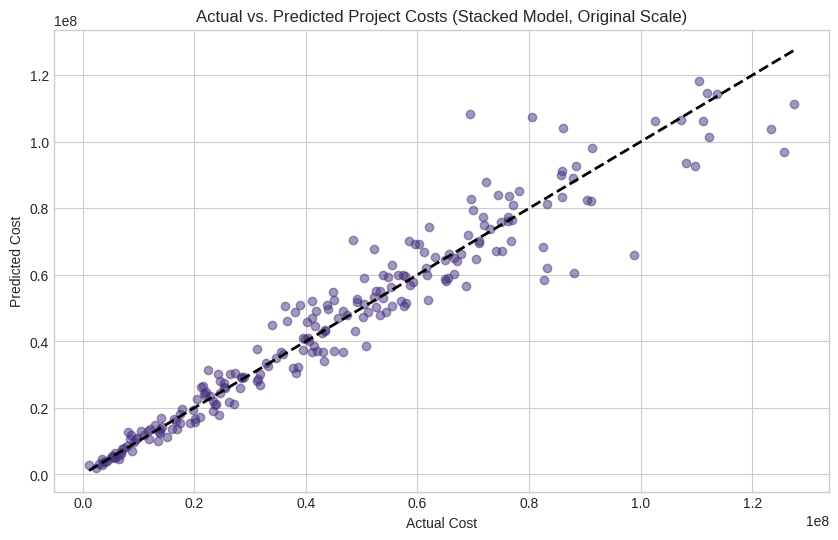

In [ ]:
                                                                                            # =========================
                                                                                     # Stacked Model (Random Forest + XGBoost)
                                                                                            # =========================


# =========================
print("\n====== Training Stacked Model ======")

# Check if data is available for training
# Use X_train, y_train_transformed for training; X_test, y_test_eval for evaluation
if X_train is not None and y_train_transformed is not None and X_test is not None and y_test_eval is not None:
    try:
        # Define base estimators
        estimators = [
            # Train base estimators on scaled features and transformed target
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=43))
        ]

        # Define the meta-estimator
        # The meta-estimator is trained on the predictions of the base estimators
        meta_estimator = RidgeCV()

        # Create the Stacking Regressor model
        # cv=5: use 5-fold cross-validation for training the meta-estimator
        # passthrough=False: do not pass original features to the meta-estimator
        stacked_model = StackingRegressor(estimators=estimators,
                                        final_estimator=meta_estimator,
                                        cv=5,
                                        passthrough=False
                                        )

        # Train the stacked model on the scaled features and transformed target
        print("\nTraining the stacked model on transformed target variable...")
        stacked_model.fit(X_train, y_train_transformed) # Fit using transformed target
        print("Stacked model training complete.")

        # Make predictions on the scaled test set (predictions will be in log-transformed scale)
        y_pred_stacked_transformed = stacked_model.predict(X_test)
        print("\nPredictions made on the test set (in log-transformed scale).")

        # Inverse transform the predictions back to the original scale
        y_pred_stacked = np.expm1(y_pred_stacked_transformed) # Inverse of log1p
        print("Inverse transformed predictions back to original scale.")


        # Evaluate the stacked model using inverse transformed predictions and original y_test
        # y_test_eval holds the original y_test values
        print("\nEvaluating Stacked model on original scale...")
        mse_stacked = mean_squared_error(y_test_eval, y_pred_stacked)
        mae_stacked = mean_absolute_error(y_test_eval, y_pred_stacked)
        rmse_stacked = np.sqrt(mse_stacked)
        r2_stacked = r2_score(y_test_eval, y_pred_stacked)
        mape_stacked = calculate_mape(y_test_eval, y_pred_stacked)

        # Store metrics and predictions
        results['Stacked'] = {
            'RMSE': rmse_stacked,
            'MAE': mae_stacked,
            'R-squared': r2_stacked,
            'MAPE': mape_stacked
        }
        predictions['Stacked'] = y_pred_stacked

        print(f"\nStacked Model Evaluation (on original scale):")
        print(f"  RMSE: {results['Stacked']['RMSE']:.2f}")
        print(f"  MAE: {results['Stacked']['MAE']:.2f}")
        print(f"  R-squared: {results['Stacked']['R-squared']:.2f}")
        print(f"  MAPE: {results['Stacked']['MAPE']:.2f}%" if not np.isnan(results['Stacked']['MAPE']) else "  MAPE: N/A")


        # =========================
        # STEP 6: Visualize Stacked Model Results
        # =========================
        # Visualize using inverse transformed predictions and original y_test
        print("\nGenerating visualization (on original scale)...\n")
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_eval, y_pred_stacked, alpha=0.5)
        # Add a diagonal line for perfect prediction: use the min/max of the combined actual and predicted values for the line
        min_val = min(y_test_eval.min(), y_pred_stacked.min())
        max_val = max(y_test_eval.max(), y_pred_stacked.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual Cost")
        plt.ylabel("Predicted Cost")
        plt.title("Actual vs. Predicted Project Costs (Stacked Model, Original Scale)")
        plt.grid(True)
        plt.show()

        # Optional: Plot learning curve for the stacked model (can be complex)
        # Note: Learning curve for stacked models can be tricky to interpret directly
        # If you want to plot it, consider using a single base estimator or the meta-estimator
        # print("\nLearning curve plotting for stacked model is complex and skipped.")


    except Exception as e:
        print(f"\nError during Stacked model training, evaluation, or visualization: {e}")
else:
    print("\nSkipping Stacked model training, evaluation, and visualization due to missing data.")


====== Comparing Model Results and Visualizing ======

Generating comparison visualizations...

Generating comparison bar plots...



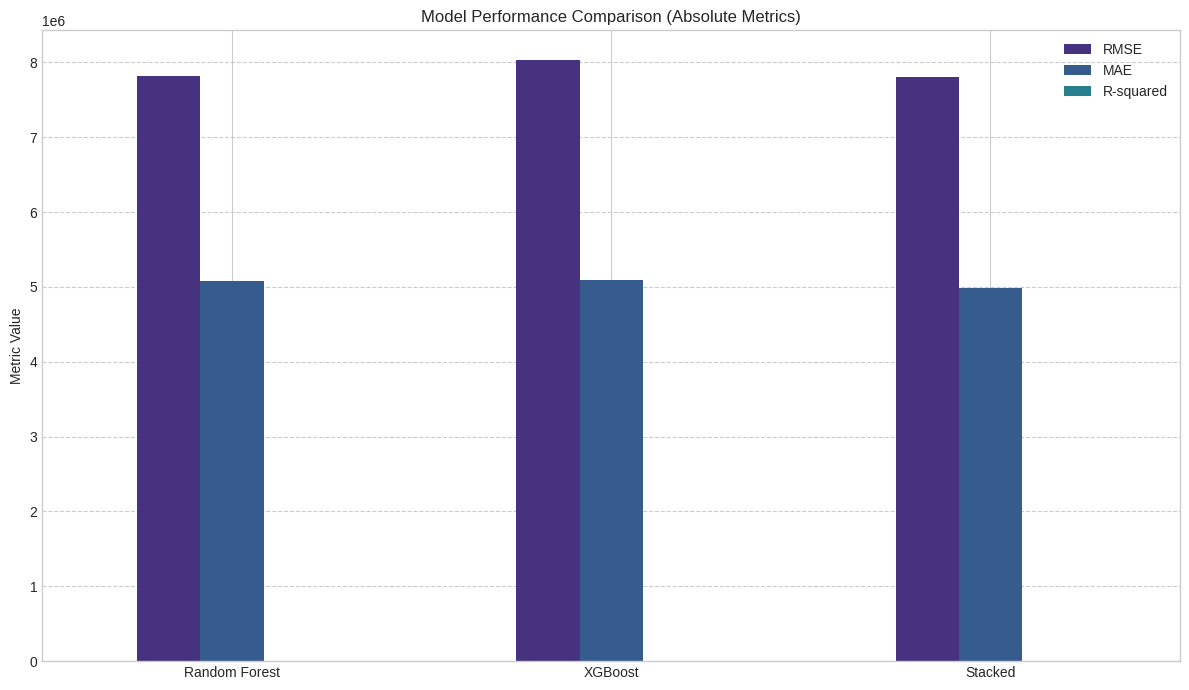


Generating MAPE bar plot...



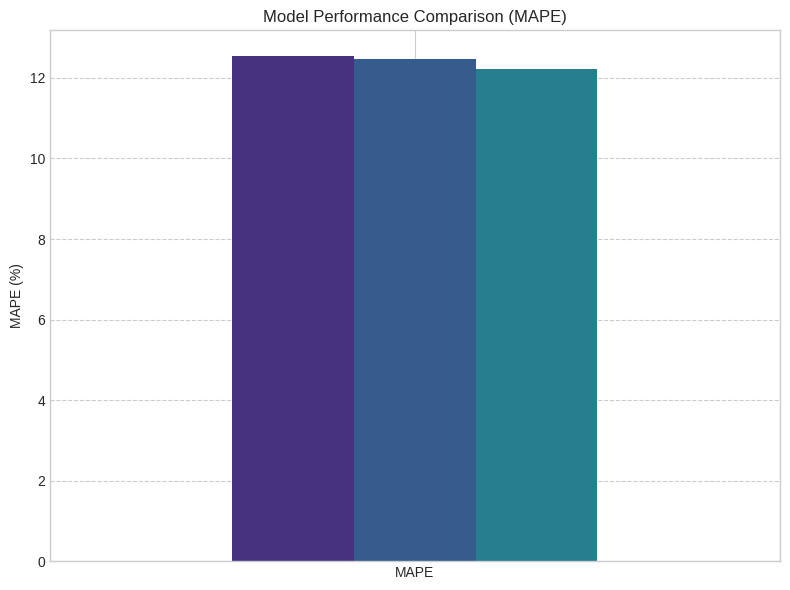


Generating comparison scatter plots...



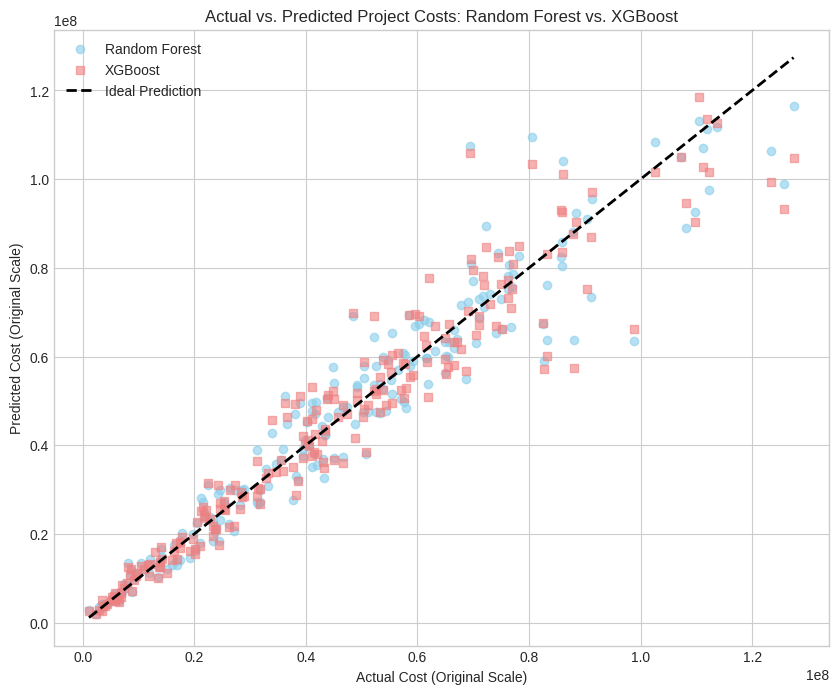

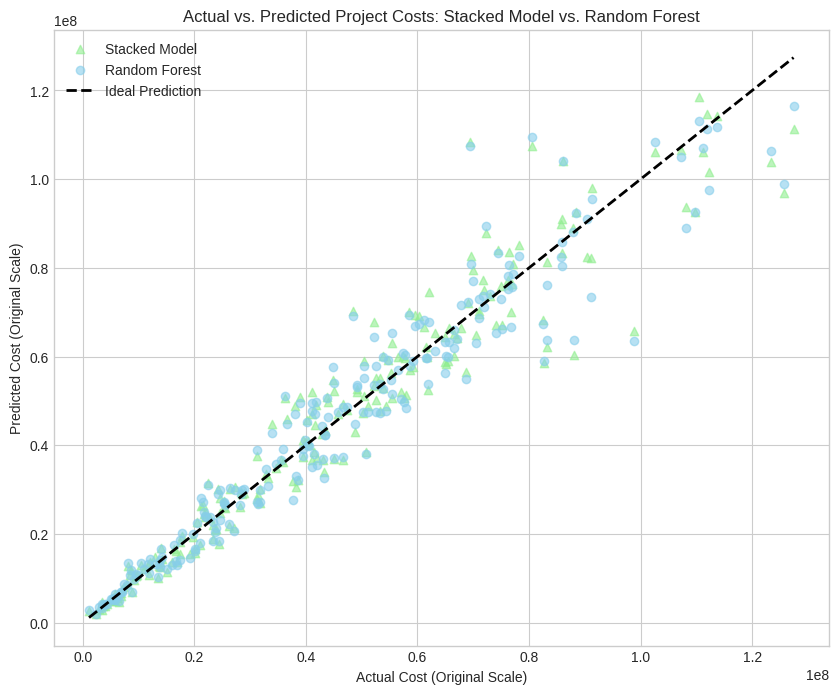

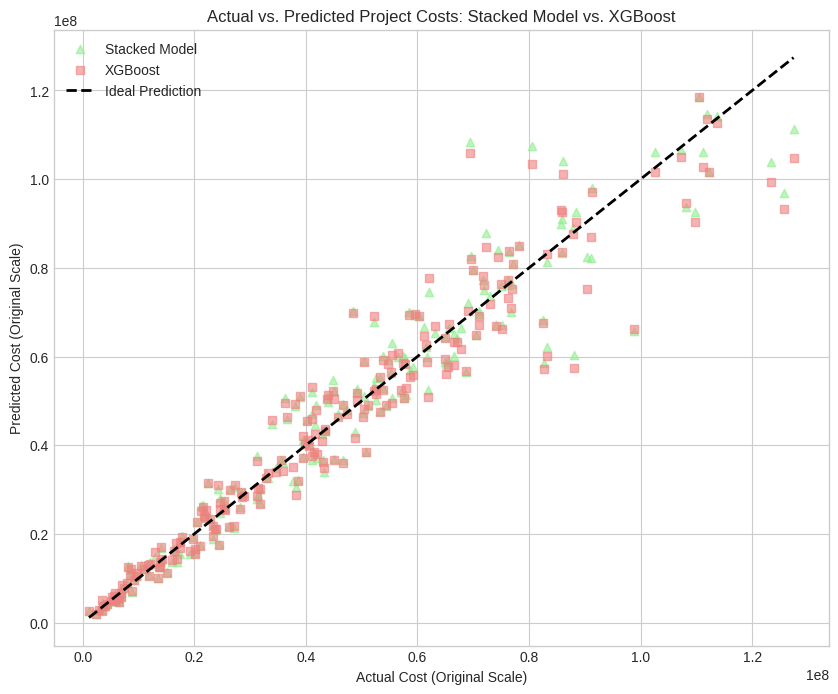

In [ ]:
# =========================
# STEP 10: Compare Model Results and Visualize
# =========================
print("\n====== Comparing Model Results and Visualizing ======")

# Check if necessary data and results/predictions are available
# Use y_test_eval for actual values in scatter plots
if results and predictions and y_test_eval is not None:
    print("\nGenerating comparison visualizations...")

    try:
        # --- Bar Plot for Absolute Metrics (RMSE, MAE, R-squared) ---
        print("\nGenerating comparison bar plots...\n")
        # Ensure all models being compared have these metrics stored
        metrics_to_compare = ['RMSE', 'MAE', 'R-squared']
        # Filter results to only include models that have all metrics
        filtered_results = {model: metrics for model, metrics in results.items() if all(metric in metrics for metric in metrics_to_compare)}

        if filtered_results:
            metrics_df_abs = pd.DataFrame(filtered_results).T[metrics_to_compare]
            metrics_df_abs.plot(kind='bar', figsize=(12, 7))
            plt.title('Model Performance Comparison (Absolute Metrics)')
            plt.ylabel('Metric Value')
            plt.xticks(rotation=0)
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()
            plt.show()
        else:
             print("\nSkipping absolute metrics bar plot as no models with complete metrics found.")

        # --- Bar Plot for Percentage Metric (MAPE) ---
        print("\nGenerating MAPE bar plot...\n")
        # Filter out NaN MAPE values if any and check if MAPE exists for models
        mape_results = {model: metrics['MAPE'] for model, metrics in results.items() if 'MAPE' in metrics and not np.isnan(metrics['MAPE'])}

        if mape_results:
            mape_df = pd.DataFrame({'MAPE': mape_results}).T
            mape_df.plot(kind='bar', figsize=(8, 6), legend=False)
            plt.title('Model Performance Comparison (MAPE)')
            plt.ylabel('MAPE (%)')
            plt.xticks(rotation=0)
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()
            plt.show()
        else:
            print("\nSkipping MAPE bar plot as MAPE could not be calculated or is missing for any model.")


        print("\nGenerating comparison scatter plots...\n")
        # --- Scatter Plot 1: Random Forest vs. XGBoost ---
        # Use y_test_eval for actual costs and predictions from the dictionary
        if 'Random Forest' in predictions and 'XGBoost' in predictions:
            plt.figure(figsize=(10, 8))
            plt.scatter(y_test_eval, predictions['Random Forest'], alpha=0.6, label='Random Forest', color='skyblue', marker='o')
            plt.scatter(y_test_eval, predictions['XGBoost'], alpha=0.6, label='XGBoost', color='lightcoral', marker='s')

            # Use min/max of actual and both sets of predictions for the ideal line
            all_values = np.concatenate([y_test_eval, predictions['Random Forest'], predictions['XGBoost']])
            min_val = np.min(all_values)
            max_val = np.max(all_values)
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Prediction')

            plt.xlabel("Actual Cost (Original Scale)")
            plt.ylabel("Predicted Cost (Original Scale)")
            plt.title("Actual vs. Predicted Project Costs: Random Forest vs. XGBoost")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
             print("\nSkipping Random Forest vs. XGBoost scatter plot due to missing predictions.")

        # --- Scatter Plot 2: Stacked Model vs. Random Forest ---
        # Use y_test_eval for actual costs and predictions from the dictionary
        if 'Stacked' in predictions and 'Random Forest' in predictions:
            plt.figure(figsize=(10, 8))
            plt.scatter(y_test_eval, predictions['Stacked'], alpha=0.6, label='Stacked Model', color='lightgreen', marker='^')
            plt.scatter(y_test_eval, predictions['Random Forest'], alpha=0.6, label='Random Forest', color='skyblue', marker='o')

            # Use min/max of actual and both sets of predictions for the ideal line
            all_values = np.concatenate([y_test_eval, predictions['Stacked'], predictions['Random Forest']])
            min_val = np.min(all_values)
            max_val = np.max(all_values)
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Prediction')

            plt.xlabel("Actual Cost (Original Scale)")
            plt.ylabel("Predicted Cost (Original Scale)")
            plt.title("Actual vs. Predicted Project Costs: Stacked Model vs. Random Forest")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
             print("\nSkipping Stacked vs. Random Forest scatter plot due to missing predictions.")

        # --- Scatter Plot 3: Stacked Model vs. XGBoost ---
        # Use y_test_eval for actual costs and predictions from the dictionary
        if 'Stacked' in predictions and 'XGBoost' in predictions:
            plt.figure(figsize=(10, 8))
            plt.scatter(y_test_eval, predictions['Stacked'], alpha=0.6, label='Stacked Model', color='lightgreen', marker='^')
            plt.scatter(y_test_eval, predictions['XGBoost'], alpha=0.6, label='XGBoost', color='lightcoral', marker='s')

            # Use min/max of actual and both sets of predictions for the ideal line
            all_values = np.concatenate([y_test_eval, predictions['Stacked'], predictions['XGBoost']])
            min_val = np.min(all_values)
            max_val = np.max(all_values)
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Prediction')

            plt.xlabel("Actual Cost (Original Scale)")
            plt.ylabel("Predicted Cost (Original Scale)")
            plt.title("Actual vs. Predicted Project Costs: Stacked Model vs. XGBoost")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
             print("\nSkipping Stacked vs. XGBoost scatter plot due to missing predictions.")

    except Exception as e:
        print(f"\nError during comparison visualization: {e}")

else:
    print("\nSkipping comparison visualizations as model results, predictions, or test data are missing.")

In [ ]:
!pip install pyDOE2

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25523 sha256=ae16f32607f59663c3ae457ae0eafb754019611a67d25a733b8dc298bcba5b56
  Stored in directory: /root/.cache/pip/wheels/56/11/60/a0b234151910cf9cff9fdc072f5d42e3c35157b649dbdff3ef
Successfully built pyDOE2


In [ ]:
# ==============================================================================
# PART 1: Data Preparation and Model Training
# ==============================================================================

# =========================
# STEP 1: Upload the Excel File
# =========================
# This step uses Google Colab specific functionality to upload a file.
# If you are not in Google Colab, you would use a different method to load your file,
# e.g., reading directly from a local path using pandas:
# import pandas as pd
# filename = 'your_file_path.xlsx'
# df = pd.read_excel(filename)
try:
    from google.colab import files
    print("Running in Google Colab. Prompting for file upload...")
    uploaded = files.upload()  # This will prompt you to upload your Excel file
    filename = next(iter(uploaded))
    print(f"File '{filename}' uploaded.")
except ImportError:
    print("Not running in Google Colab. Please adjust file loading path.")
    # Example for local file:
    # filename = 'your_local_file.xlsx'
    # Make sure pandas is imported if you uncomment this section
    # import pandas as pd
    # df = pd.read_excel(filename)
    # print(f"Reading file from local path: {filename}")
    pass # Keep this if you are manually handling file loading outside Colab

# =========================
# STEP 2: Read the Excel File
# =========================
import pandas as pd

# If running outside Colab and used the local file example above, skip this part
if 'df' not in locals(): # Check if df was already created by the local load example
    try:
        df = pd.read_excel(filename)
        print("Excel file read successfully. First 5 rows:")
        print(df.head())
    except NameError:
        print("Filename not defined. Please upload a file in Colab or specify a local file path.")
        # Exit or handle the error appropriately if df is not loaded
        raise SystemExit("Original Excel file not loaded.")
    except FileNotFoundError:
         print(f"Error: File not found at {filename}. Please check the path.")
         raise SystemExit("Original Excel file not found.")


# =========================
# STEP 3: Prepare Features and Target (Use All Parameters, Handle Dates)
# =========================

exclude_cols = [
    'Project_ID',      # Identifier, not a feature
    'Actual_Cost'      # Target variable
]

# Identify categorical columns (object or string types)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Identify datetime columns
datetime_cols = df.select_dtypes(include=['datetime', 'datetime64[ns]']).columns.tolist()

# Option 1: Convert dates to numeric features (example: project duration)
# Make sure 'Start_Date' and 'End_Date' exist before trying to calculate duration
if 'Start_Date' in df.columns and 'End_Date' in df.columns:
    print("\nCalculating Project Duration...")
    # Ensure date columns are datetime objects before calculating difference
    df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce')
    df['End_Date'] = pd.to_datetime(df['End_Date'], errors='coerce')
    # Calculate duration, handling potential NaT values from coercion
    df['Project_Duration_Days'] = (df['End_Date'] - df['Start_Date']).dt.days.fillna(0) # Fill NaNs with 0 or another strategy
    print("Project Duration calculation complete.")
else:
    print("\n'Start_Date' or 'End_Date' columns not found. Skipping duration calculation.")


# Drop original datetime columns
df = df.drop(columns=datetime_cols, errors='ignore') # Use errors='ignore' in case cols don't exist

# One-hot encode categorical columns
print("Encoding categorical features...")
# Handle potential non-string types in categorical columns before encoding
for col in categorical_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype(str) # Convert to string to avoid errors in get_dummies
# Select only columns that are still in the dataframe after dropping datetime
categorical_cols_present = [col for col in categorical_cols if col in df.columns]
df_encoded = pd.get_dummies(df, columns=categorical_cols_present, drop_first=True)
print("Categorical encoding complete.")

# Prepare features (X) and target (y)
# X holds the preprocessed features
feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]
X = df_encoded[feature_cols]
y = df['Actual_Cost'] # y holds the target variable

print("\nData preparation complete.")
print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("\nFeatures after encoding (first 5 rows):")
print(X.head())

# =========================
# STEP 4: Split Data into Train and Test Sets
# =========================
from sklearn.model_selection import train_test_split

print("\nSplitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Data split complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


# =========================
# STEP 5: Normalize Features (Removed for Stacking of Tree-based models)
# =========================
# StandardScaler is generally not needed for tree-based models like Random Forest and XGBoost.
# This step is omitted from this version.


# =========================
# STEP 6: Build and Train Stacked Model (Random Forest + XGBoost)
# =========================
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV # A common choice for the meta-estimator
import xgboost as xgb
# No need for metrics import here, will import in evaluation section

# Define base estimators
# Use slightly different random states or parameters if you want more diversity
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)), # n_jobs=-1 uses all available cores
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=43, n_jobs=-1)) # n_jobs=-1 uses all available cores
]

# Define the meta-estimator
# RidgeCV is a good default as it includes cross-validation for regularization
meta_estimator = RidgeCV()

# Create the Stacking Regressor model
print("\nSetting up Stacking Regressor...")
stacked_model = StackingRegressor(estimators=estimators,
                                  final_estimator=meta_estimator,
                                  cv=5, # Using 5-fold cross-validation to train the meta-estimator
                                  passthrough=False # Set to True if you want the meta-model to see original features too
                                 )

# Train the stacked model
print("Training the stacked model...")
# Ensure y_train is in the correct format (e.g., flattened if it's a Series/DataFrame)
if isinstance(y_train, (pd.Series, pd.DataFrame)):
    y_train_flat = y_train.values.flatten()
else:
    y_train_flat = y_train.flatten()

stacked_model.fit(X_train, y_train_flat)
print("Stacked model training complete.")

# =========================
# STEP 7, 8 (Implicit): Make Predictions on Test Set (for evaluation)
# =========================
# Make predictions on the test set using the trained stacked model
print("Making predictions on the test set for evaluation...")
y_pred_stacked = stacked_model.predict(X_test)
print("Predictions made.")

print("\nPART 1 (Data Preparation and Model Training) Complete.")

Running in Google Colab. Prompting for file upload...


Saving data_with_embeddings.xlsx to data_with_embeddings (25).xlsx
File 'data_with_embeddings (25).xlsx' uploaded.

'Start_Date' or 'End_Date' columns not found. Skipping duration calculation.
Encoding categorical features...
Categorical encoding complete.

Data preparation complete.
Features shape (X): (1117, 1173)
Target shape (y): (1117,)

Features after encoding (first 5 rows):
   Planned_Cost  Cost_Overrun  Planned_Duration  Actual_Duration  \
0    12260784.0  2.793720e+06             699.0       850.984231   
1    23299783.0 -1.607656e+06             899.0      1695.934895   
2    24499306.0  4.970354e+06             809.0      1308.192026   
3    16711072.0  6.978281e+06             255.0       400.203978   
4    42776934.0  1.625532e+07             842.0       803.945505   

   Schedule_Deviation  Vibration_Level  Crack_Width  Load_Bearing_Capacity  \
0          114.914852         1.534172     2.809385             471.197381   
1          182.777915         0.951146     3.30930

In [ ]:
# =========================
# STEP 9: Perform Monte Carlo Simulation
# =========================
print("\nStarting Monte Carlo Simulation...")

n_simulations = 1000 # Define the number of simulation runs

# Add debugging: Check shape of X_test
print(f"DEBUG: X_test shape before simulation: {X_test.shape}")

# To introduce noise, we can use the standard deviation of features from the training data
# Add a small constant to std_dev to avoid division by zero or issues with zero-variance features
# We will apply noise additively, scaled by the feature standard deviation
feature_std_dev = X_train.std() + 1e-6 # Add a small epsilon to avoid zero std dev issues

# Add debugging: Check shape and values of feature_std_dev
print(f"DEBUG: feature_std_dev shape: {feature_std_dev.shape}")
print(f"DEBUG: feature_std_dev (first 5): {feature_std_dev.values[:5]}")
print(f"DEBUG: feature_std_dev stats: mean={feature_std_dev.mean():.4f}, max={feature_std_dev.max():.4f}")


# Prepare a list to store predictions from each simulation
monte_carlo_predictions = []

for i in range(n_simulations):
    # Generate noise for X_test
    noise = np.random.randn(*X_test.shape) * feature_std_dev.values

    # Add debugging: Check noise shape and stats for the first few simulations
    if i < 5 or i % 100 == 0: # Print for first 5 and every 100th simulation
        print(f"DEBUG (Sim {i+1}): Noise shape: {noise.shape}")
        print(f"DEBUG (Sim {i+1}): Noise stats: mean={noise.mean():.4f}, std={noise.std():.4f}, min={noise.min():.4f}, max={noise.max():.4f}")
        print(f"DEBUG (Sim {i+1}): Noise (first row, first 5 features): {noise[0, :5]}")


    # Add noise to the test features
    X_test_perturbed = X_test + noise

    # Add debugging: Check perturbed data shape, stats, and NaNs/Infs
    if i < 5 or i % 100 == 0:
        print(f"DEBUG (Sim {i+1}): X_test_perturbed shape: {X_test_perturbed.shape}")
        print(f"DEBUG (Sim {i+1}): X_test_perturbed stats: mean={X_test_perturbed.values.mean():.4f}, std={X_test_perturbed.values.std():.4f}, min={X_test_perturbed.values.min():.4f}, max={X_test_perturbed.values.max():.4f}")
        if np.any(np.isnan(X_test_perturbed)) or np.any(np.isinf(X_test_perturbed)):
             print(f"DEBUG (Sim {i+1}): WARNING: NaN or Inf found in X_test_perturbed!")


    # Make predictions with the perturbed data
    y_pred_perturbed = stacked_model.predict(X_test_perturbed)

    # Add debugging: Check prediction shape and NaNs/Infs
    if i < 5 or i % 100 == 0:
        print(f"DEBUG (Sim {i+1}): y_pred_perturbed shape: {y_pred_perturbed.shape}")
        if np.any(np.isnan(y_pred_perturbed)) or np.any(np.isinf(y_pred_perturbed)):
             print(f"DEBUG (Sim {i+1}): WARNING: NaN or Inf found in y_pred_perturbed!")
        print(f"DEBUG (Sim {i+1}): y_pred_perturbed (first 5): {y_pred_perturbed[:5]}")


    # Store the predictions
    monte_carlo_predictions.append(y_pred_perturbed)

# Convert the list of prediction arrays into a single numpy array
monte_carlo_predictions = np.array(monte_carlo_predictions)

print(f"Monte Carlo Simulation complete after {n_simulations} runs.")

# Add debugging: Check final predictions array shape and stats
print(f"DEBUG: monte_carlo_predictions shape: {monte_carlo_predictions.shape}")
print(f"DEBUG: monte_carlo_predictions stats: mean={monte_carlo_predictions.mean():.4f}, std={monte_carlo_predictions.std():.4f}, min={monte_carlo_predictions.min():.4f}, max={monte_carlo_predictions.max():.4f}")


# Analyze the results of the Monte Carlo Simulation
# For each prediction, we have n_simulations values.
# We can calculate the mean prediction and the standard deviation/confidence interval for each data point.

# Calculate the mean prediction across all simulations for each data point in X_test
mean_mc_prediction = np.mean(monte_carlo_predictions, axis=0)

# Calculate the standard deviation of predictions across all simulations for each data point
std_dev_mc_prediction = np.std(monte_carlo_predictions, axis=0)

print("\nMonte Carlo Simulation Analysis:")
print(f"Mean prediction across simulations (first 5): {mean_mc_prediction[:5]}")
print(f"Standard deviation of predictions across simulations (first 5): {std_dev_mc_prediction[:5]}")

# You can further analyze these results, e.g., calculate confidence intervals,
# visualize the distribution of predictions for a specific data point, etc.

print("\nPART 2 (Monte Carlo Simulation) Complete.")

# ... rest of the code ...


Starting Monte Carlo Simulation...
DEBUG: X_test shape before simulation: (224, 1173)
DEBUG: feature_std_dev shape: (1173,)
DEBUG: feature_std_dev (first 5): [1.67652044e+07 5.62913569e+06 2.49976889e+02 4.51892920e+02
 1.03692783e+02]
DEBUG: feature_std_dev stats: mean=19106.0756, max=16765204.4251
DEBUG (Sim 1): Noise shape: (224, 1173)
DEBUG (Sim 1): Noise stats: mean=1508.1319, std=514935.7011, min=-46937300.7254, max=51968492.4840
DEBUG (Sim 1): Noise (first row, first 5 features): [ 1.45070374e+07 -3.31649737e+05 -1.31570206e+02 -3.64968707e+02
 -8.10572630e+01]
DEBUG (Sim 1): X_test_perturbed shape: (224, 1173)
DEBUG (Sim 1): X_test_perturbed stats: mean=30487.6456, std=1152393.3334, min=-24777142.3261, max=87324879.4840
DEBUG (Sim 1): y_pred_perturbed shape: (224,)
DEBUG (Sim 1): y_pred_perturbed (first 5): [-2.79316649e+10 -2.29976939e+11  2.53004750e+10 -5.68762773e+10
 -8.10962148e+10]
DEBUG (Sim 2): Noise shape: (224, 1173)
DEBUG (Sim 2): Noise stats: mean=-1059.9472, std=


Evaluating model performance...
Mean Absolute Error (MAE): 152695956121.3194
Mean Squared Error (MSE): 33415157391186750078976.0000
Root Mean Squared Error (RMSE): 182798132898.5248
R-squared (R2): -39132501.7360
Model evaluation complete.

Generating prediction vs. actuals plot...


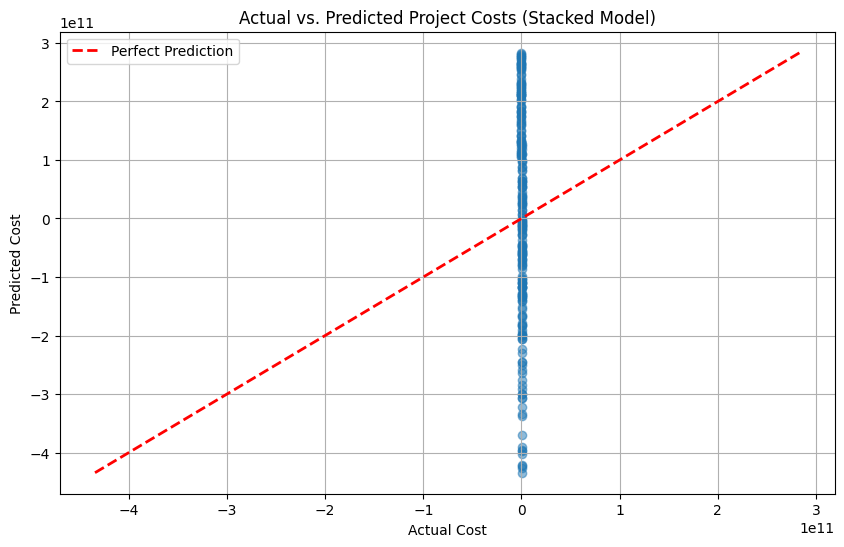

Prediction vs. actuals plot generated.

PART 3 (Evaluation and Visualization) Complete.


In [ ]:
# =========================
# STEP 10: Evaluate Model Performance
# =========================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Make sure numpy is imported if not already

print("\nEvaluating model performance...")

# Calculate evaluation metrics for the original stacked model predictions
mae = mean_absolute_error(y_test, y_pred_stacked)
mse = mean_squared_error(y_test, y_pred_stacked)
rmse = np.sqrt(mse) # RMSE is the square root of MSE
r2 = r2_score(y_test, y_pred_stacked)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

print("Model evaluation complete.")

# =========================
# STEP 11: Visualize Predictions vs. Actuals
# =========================
import matplotlib.pyplot as plt

print("\nGenerating prediction vs. actuals plot...")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_stacked, alpha=0.5) # Scatter plot of actual vs predicted values
plt.title('Actual vs. Predicted Project Costs (Stacked Model)')
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.grid(True)

# Add a line for perfect predictions (y=x)
min_val = min(y_test.min(), y_pred_stacked.min())
max_val = max(y_test.max(), y_pred_stacked.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.legend()

plt.show() # Display the plot

print("Prediction vs. actuals plot generated.")

# Optional: You could also visualize the distribution of Monte Carlo predictions for a specific data point
# For example, for the first test data point (index 0):
# plt.figure(figsize=(8, 5))
# plt.hist(monte_carlo_predictions[:, 0], bins=50, alpha=0.7, label='Simulated Predictions')
# plt.axvline(y_test.iloc[0] if isinstance(y_test, pd.Series) else y_test[0], color='red', linestyle='--', label='Actual Cost')
# plt.axvline(y_pred_stacked[0], color='green', linestyle='-', label='Stacked Model Prediction')
# plt.title(f'Monte Carlo Prediction Distribution for Data Point 0')
# plt.xlabel('Predicted Cost')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()


print("\nPART 3 (Evaluation and Visualization) Complete.")

In [ ]:
# =========================
# STEP 13: Monte Carlo Simulation with LHS and Correlation
# =========================

n_simulations = 1000

# Define custom bins and labels for cost tiers
bins = [float('-inf'), 0.15e8, 0.8e8, float('inf')]
labels = ['Low', 'Medium', 'High']

# Assign each historical project to a cost tier based on Planned_Cost
cost_tiers = pd.cut(df['Planned_Cost'], bins=bins, labels=labels)

# Calculate historical cost overruns
df['Cost_Overrun'] = df['Actual_Cost'] - df['Planned_Cost']

# Prepare to collect simulation results
sim_pred_actual_cost = []
sim_planned_cost = []
sim_tier = []

# For each tier, simulate n_simulations//3 samples (or proportional to tier size)
for tier in labels:
    # Get historical overrun stats for this tier
    tier_mask = (cost_tiers == tier)
    tier_overruns = df.loc[tier_mask, 'Cost_Overrun'].dropna()
    tier_planned = df.loc[tier_mask, 'Planned_Cost'].dropna()

    if len(tier_overruns) < 2:
        continue  # Skip if not enough data in this tier

    # Estimate mean and std of cost overruns for this tier
    overrun_mean = tier_overruns.mean()
    overrun_std = tier_overruns.std()

    # Simulate planned costs for this tier
    planned_mean = tier_planned.mean()
    planned_std = tier_planned.std()
    n_tier_sim = n_simulations // len(labels)

    # Simulate planned costs
    sim_planned = np.random.normal(planned_mean, planned_std, n_tier_sim)
    # Simulate cost overruns
    sim_overrun = np.random.normal(overrun_mean, overrun_std, n_tier_sim)
    # Simulate actual costs
    sim_actual = sim_planned + sim_overrun

    sim_pred_actual_cost.extend(sim_actual)
    sim_planned_cost.extend(sim_planned)
    sim_tier.extend([tier]*n_tier_sim)

# Convert results to arrays
sim_pred_actual_cost = np.array(sim_pred_actual_cost)
sim_planned_cost = np.array(sim_planned_cost)
sim_tier = np.array(sim_tier)

# Calculate cost overrun probability for each tier
for tier in labels:
    mask = (sim_tier == tier)
    prob_overrun = np.mean(sim_pred_actual_cost[mask] > sim_planned_cost[mask])
    print(f"Estimated Probability of Cost Overrun for {tier} Cost Projects: {prob_overrun:.2%}")

NameError: name 'pd' is not defined

In [ ]:
# =========================
# STEP 14: Evaluate the Monte Carlo Simulation
# =========================

# Calculate simulated cost overruns for each sample
sim_cost_overrun = sim_pred_actual_cost - sim_planned_cost

# Create a DataFrame for evaluation
eval_df = pd.DataFrame({
    'Simulated Actual Cost': sim_pred_actual_cost,
    'Simulated Planned Cost': sim_planned_cost,
    'Simulated Cost Overrun': sim_cost_overrun,
    'Cost Tier': sim_tier
})

# Print summary statistics for each tier
for tier in labels:
    tier_mask = (eval_df['Cost Tier'] == tier)
    tier_overruns = eval_df.loc[tier_mask, 'Simulated Cost Overrun']
    if len(tier_overruns) < 2:
        print(f"\n{tier} Cost Tier: Not enough data for evaluation.")
        continue
    print(f"\n{tier} Cost Tier:")
    print(f"  Mean Overrun: {tier_overruns.mean():.2f}")
    print(f"  Median Overrun: {tier_overruns.median():.2f}")
    print(f"  90th Percentile Overrun: {np.percentile(tier_overruns, 90):.2f}")
    print(f"  95th Percentile Overrun: {np.percentile(tier_overruns, 95):.2f}")
    prob_overrun = np.mean(tier_overruns > 0)
    print(f"  Probability of Overrun: {prob_overrun:.2%}")

# Boxplot of simulated cost overruns by tier
plt.figure(figsize=(8,6))
eval_df.boxplot(column='Simulated Cost Overrun', by='Cost Tier', grid=False)
plt.title('Simulated Cost Overruns by Cost Tier (Monte Carlo)')
plt.suptitle('')
plt.xlabel('Cost Tier')
plt.ylabel('Simulated Cost Overrun')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

# Histogram of cost overruns
plt.figure(figsize=(10,6))
plt.hist(cost_overrun_amount, bins=30, alpha=0.7, color='crimson')
plt.axvline(0, color='black', linestyle='--', label='No Overrun')
plt.xlabel('Cost Overrun (Predicted Actual - Planned)')
plt.ylabel('Frequency')
plt.title('Histogram of Cost Overruns (Monte Carlo Simulation)')
plt.legend()
plt.show()

# Cumulative Distribution Function (CDF) of cost overruns
sorted_overruns = np.sort(cost_overrun_amount)
cdf = np.arange(1, len(sorted_overruns)+1) / len(sorted_overruns)

plt.figure(figsize=(10,6))
plt.plot(sorted_overruns, cdf, color='navy')
plt.axvline(0, color='black', linestyle='--', label='No Overrun')
plt.xlabel('Cost Overrun (Predicted Actual - Planned)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Cost Overruns (Monte Carlo Simulation)')
plt.legend()
plt.grid(True)
plt.show()

# =========================
# STEP 16: Scatter Plot of Predictions (Predicted Cost vs Actual Cost)
# =========================
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Scatter Plot: Predicted Cost vs Actual Cost')
plt.grid(True)
plt.show()

# =========================
# STEP 15: Compare Results Before and After Simulation
# =========================

# 1. Predicted Actual Cost on the real test set (before simulation)
y_pred_test = model.predict(X_test).flatten()

# 2. Predicted Actual Cost from Monte Carlo simulation (after simulation)
# Already stored in sim_pred_actual_cost

import matplotlib.pyplot as plt

# --- Histogram Comparison ---
plt.figure(figsize=(12,6))
plt.hist(y_pred_test, bins=30, alpha=0.7, label='Test Set Predictions (Before Simulation)')
plt.hist(sim_pred_actual_cost, bins=30, alpha=0.7, label='Monte Carlo Simulation (After Simulation)')
plt.xlabel('Predicted Actual Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Actual Cost: Test Set vs Monte Carlo Simulation')
plt.legend()
plt.show()

# --- Boxplot Comparison ---
plt.figure(figsize=(8,6))
plt.boxplot([y_pred_test, sim_pred_actual_cost], labels=['Test Set', 'Simulation'])
plt.ylabel('Predicted Actual Cost')
plt.title('Boxplot: Test Set vs Monte Carlo Simulation')
plt.show()

# --- Overrun Probability Comparison ---
# Calculate overrun probability for test set
planned_cost_test = df.loc[y_test.index, 'Planned_Cost']
test_overrun = y_pred_test > planned_cost_test
prob_overrun_test = np.mean(test_overrun)

print(f"Probability of Cost Overrun (Test Set): {prob_overrun_test:.2%}")
print(f"Probability of Cost Overrun (Simulation): {prob_overrun:.2%}")

# =========================
plt.figure(figsize=(12,6))
plt.hist(df['Actual_Cost'], bins=30, alpha=0.7, label='Actual Cost (Dataset)')
plt.hist(sim_pred_actual_cost, bins=30, alpha=0.7, label='Predicted Cost (Simulation)')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Actual Cost (Dataset) vs Predicted Cost (Monte Carlo Simulation)')
plt.legend()
plt.show()

NameError: name 'sim_pred_actual_cost' is not defined

<Figure size 800x600 with 0 Axes>

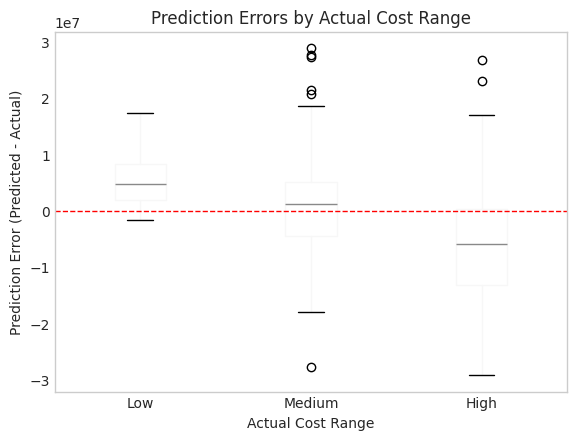

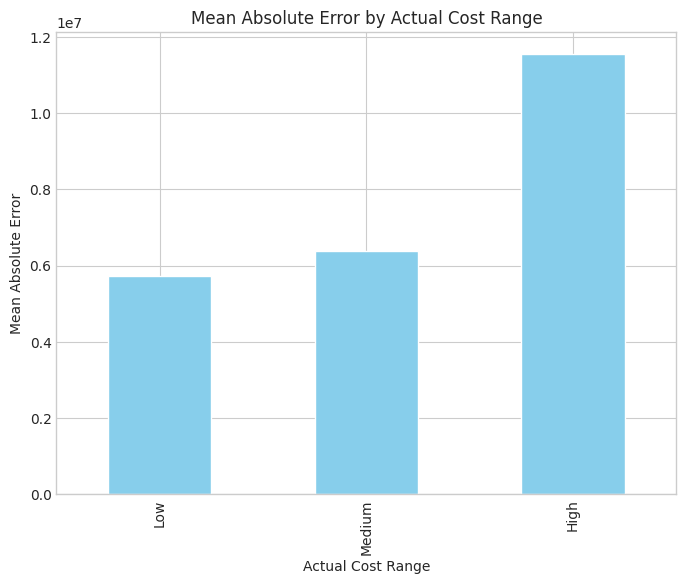

In [ ]:
# =========================
# STEP 15: Visualize Prediction Errors by Cost Range
# =========================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate prediction errors
errors = y_pred - y_test

# Define custom bins and labels
bins = [float('-inf'), 0.15e8, 0.8e8, float('inf')]
labels = ['Low', 'Medium', 'High']

# Bin actual costs into custom ranges
cost_bins = pd.cut(y_test, bins=bins, labels=labels)

# Create a DataFrame for plotting
error_df = pd.DataFrame({
    'Actual Cost': y_test,
    'Predicted Cost': y_pred,
    'Error': errors,
    'Cost Range': cost_bins
})

# Boxplot of errors by cost range
plt.figure(figsize=(8,6))
error_df.boxplot(column='Error', by='Cost Range', grid=False)
plt.title('Prediction Errors by Actual Cost Range')
plt.suptitle('')
plt.xlabel('Actual Cost Range')
plt.ylabel('Prediction Error (Predicted - Actual)')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

mae_by_range = error_df.groupby('Cost Range')['Error'].apply(lambda x: np.mean(np.abs(x)))

plt.figure(figsize=(8,6))
mae_by_range.plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Error by Actual Cost Range')
plt.xlabel('Actual Cost Range')
plt.ylabel('Mean Absolute Error')
plt.show()